# Predictive Model w/ Segmentation

## Setup

In [74]:
import pandas as pd
import pysam
import numpy as np
import multiprocessing as mp
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib_venn import venn2
import sqlite3
import csv
import glob
import gffpandas.gffpandas as gffpd
from intervaltree import Interval, IntervalTree
import bisect
from tqdm import tqdm
from biomart import BiomartServer
import os
import re
import gseapy as gp
from gseapy.plot import barplot, dotplot
from gseapy import GSEA
import statsmodels.api as sm
import statsmodels.stats.multitest as smm
from scipy.stats import kruskal, mannwhitneyu, ttest_ind, f_oneway, wilcoxon, ranksums, fisher_exact, chi2_contingency, entropy, pearsonr
import json
import ast
import itertools
import sys
from venn import venn
import contextlib
from imblearn.over_sampling import SMOTE

import sklearn
from sklearn.model_selection import train_test_split, cross_val_score, LeaveOneOut
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, Lasso, ElasticNet
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score, silhouette_score, confusion_matrix, precision_score, recall_score, f1_score, roc_curve, auc, roc_auc_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.cluster import DBSCAN

### Helper Functions

In [2]:
def assert_column(df, column_name, df_name=''):
        assert column_name in df.columns, f"'{column_name}' column is missing in {df_name}"
        assert not df[column_name].isnull().all(), f"'{column_name}' column is empty in {df_name}"

In [3]:
def cpg2segment_aggregation_trees(cpg_df, segment_df):

    dataframes = {'cpg_df': ['source_directory', 'sample_id_adj', 'chrom'],
                'segment_df': ['start', 'end', 'segment_id', 'chrom', 'gene_symbol', 'length']}

    for df_name, columns in dataframes.items():
        for column in columns:
            assert_column(eval(df_name), column, df_name)

    # Filter out chromosomes from cpg_df that aren't in segment_df
    cpg_df = cpg_df[cpg_df['chrom'].isin(segment_df['chrom'].unique())]

    # Create an IntervalTree for each group
    segment_trees = {str(seq_id): IntervalTree(Interval(row.start, row.end, row.segment_id) for row in group.itertuples()) 
                     for seq_id, group in segment_df.groupby('chrom')}
    
    print("initializing meth_seg...")

    # Initialize meth_seg DataFrame
    meth_seg = pd.DataFrame(list(itertools.product(cpg_df["sample_id_adj"].unique(), 
                                                   segment_df["segment_id"].unique())),
                            columns=['sample_id_adj', 'segment_id'])
    
    meth_seg = meth_seg.merge(cpg_df[['sample_id_adj', 'source_directory']].drop_duplicates(), on='sample_id_adj', how='left')

    meth_seg = meth_seg.sort_values(['sample_id_adj']).reset_index(drop=True)
    meth_seg["total_methylation"] = 0.0
    meth_seg["positions"] = [[] for _ in range(len(meth_seg))]
    meth_seg["mod_qual_positions"] = [[] for _ in range(len(meth_seg))]
    meth_seg["num_cpgs"] = 0

    # Initialize a dictionary to store the rows
    meth_seg_dict = {(row.segment_id, row.sample_id_adj, row.source_directory): row for _, row in meth_seg.iterrows()}

    # Group the DataFrame by 'source_directory', 'sample_id_adj', and 'chrom'
    grouped = cpg_df.groupby(['source_directory', 'sample_id_adj', 'chrom'])

    for (source_directory, sample_id_adj, chrom), group in tqdm(grouped, desc="Aggregating"):
        tree = segment_trees[chrom]
        for row in group.itertuples():
            intervals = tree[row.ref_position]
            for interval in intervals:
                # Use the dictionary for lookup and update
                key = (interval.data, sample_id_adj, source_directory)
                meth_seg_row = meth_seg_dict[key]
                meth_seg_row.total_methylation += row.mod_qual
                meth_seg_row.num_cpgs += 1  # Increment the number of CpGs for this segment
                meth_seg_row.positions.append(row.ref_position)
                meth_seg_row.mod_qual_positions.append(row.mod_qual)

    # Convert the dictionary back to a DataFrame
    meth_seg = pd.DataFrame(meth_seg_dict.values())

    # Calculate the average of the values in the 'mod_quals_positions' column
    meth_seg['avg_methylation'] = meth_seg['mod_qual_positions'].apply(lambda x: np.mean(x) if x else 0)

    meth_seg = meth_seg.merge(segment_df[['segment_id', 'gene_symbol', 'length', 'chrom']], on='segment_id', how='left').sort_values("segment_id")

    # Convert the lists to strings
    meth_seg['positions'] = meth_seg['positions'].astype(str)
    meth_seg['mod_qual_positions'] = meth_seg['mod_qual_positions'].astype(str)

    # Now you can safely drop duplicates
    meth_seg = meth_seg.drop_duplicates().reset_index(drop=True)

    return meth_seg

In [4]:
def cpg2segment_aggregation_heuristic(cpg_df, segment_df):

    dataframes = {'cpg_df': ['source_directory', 'sample_id_adj', 'chrom'],
                'segment_df': ['start', 'end', 'segment_id', 'chrom']}

    for df_name, columns in dataframes.items():
        for column in columns:
            assert_column(eval(df_name), column, df_name)

    # Group cpg_df by 'source_directory', 'sample_id_adj', and 'chrom'
    grouped = cpg_df.groupby(['source_directory', 'sample_id_adj', 'chrom'])

    # For each group in cpg_df
    for (source_directory, sample_id_adj, chrom), group in grouped:

        # Print debug line
        print(f"Aggregating {source_directory}, {sample_id_adj}, {chrom}...", end='\r')
        
        # Filter segments for the current chromosome
        segments_for_chrom = segment_df[segment_df['chrom'] == chrom].reset_index(drop=True).sort_values(["start"])
        
        # Filter cpgs for the current sample
        cpgs_for_sample = group.reset_index(drop=True).sort_values(['ref_position'])

        i = 0

        meth_seg = pd.DataFrame(columns=['source_directory', 'chrom', 'sample_id_adj', 'segment_id', 'positions', 'mod_qual_positions'])
        
        # For each row in segments_for_chrom
        for idx, row in segments_for_chrom.iterrows():
            first_hit = True
            while i < len(cpgs_for_sample):
                if cpgs_for_sample.at[i, 'ref_position'] < row['start']:
                    i += 1
                elif cpgs_for_sample.at[i, 'ref_position'] >= row['end']:
                    break
                else:
                    if first_hit:
                        new_row = row.copy()
                        new_row["source_directory"] = source_directory
                        new_row["chrom"] = chrom
                        new_row["sample_id_adj"] = sample_id_adj
                        new_row["positions"] = [cpgs_for_sample.at[i, 'ref_position']]
                        new_row["mod_qual_positions"] = [cpgs_for_sample.at[i, 'mod_qual']]
                        meth_seg = pd.concat([meth_seg, pd.DataFrame(new_row).T]).reset_index(drop=True)
                        first_hit = False
                    else:
                        meth_seg.at[meth_seg.index[-1], "positions"].append(cpgs_for_sample.at[i, 'ref_position'])
                        meth_seg.at[meth_seg.index[-1], "mod_qual_positions"].append(cpgs_for_sample.at[i, 'mod_qual'])

    return meth_seg


In [5]:
def create_fm(meth_seg, metadata):
    dataframes = {
        'meth_seg': ['segment_id', 'source_directory', 'sample_id_adj', 'avg_methylation'],
        'metadata': ['source_directory', 'sample_id_adj', 'Group']
    }

    for df_name, columns in dataframes.items():
        for column in columns:
            assert_column(eval(df_name), column, df_name)

    meth_seg_pivot = meth_seg.pivot_table(index=["sample_id_adj", "source_directory"], columns="segment_id", values="avg_methylation").reset_index()
    # Fill missing values with zeros
    meth_seg_pivot = meth_seg_pivot.fillna(0)
    meth_seg_fm = meth_seg_pivot.merge(metadata[["sample_id_adj", "Group"]], on = "sample_id_adj", how = "left").drop_duplicates().reset_index(drop = True)
    # Assuming 'Group' is the column you want to move to the front
    group = meth_seg_fm.pop('Group')
    meth_seg_fm.insert(0, 'Group', group)
    meth_seg_fm.sort_values("source_directory", inplace = True)
    return meth_seg_fm

In [6]:
def pca_plot(df, n_components=2, group_column=None, label_column=None):

    # Perform PCA
    pca = PCA(n_components=n_components)
    principalComponents = pca.fit_transform(df.select_dtypes(exclude=['object']))

    # Create a DataFrame with the principal components
    principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2'])

    # Add the 'Group' column back to the DataFrame
    principalDf["group"] = df[group_column]

    # If label_column is provided, use it as label
    if label_column:
        principalDf["label"] = df[label_column]
    else:
        principalDf["label"] = df[group_column]

    # Create a scatter plot
    fig = plt.figure(figsize = (8,8))
    ax = fig.add_subplot(1,1,1) 
    ax.set_xlabel('Principal Component 1, Explained variance: {:.2%}'.format(pca.explained_variance_ratio_[0]), fontsize = 15)
    ax.set_ylabel('Principal Component 2, Explained variance: {:.2%}'.format(pca.explained_variance_ratio_[1]), fontsize = 15)
    ax.set_title('2 component PCA', fontsize = 20)

    groups = principalDf["group"].unique()
    colors = ['r', 'g', 'b', 'y']  # Add more colors if you have more groups

    for group, color in zip(groups, colors):
        indicesToKeep = principalDf["group"] == group
        scatter = ax.scatter(principalDf.loc[indicesToKeep, 'principal component 1']
                   , principalDf.loc[indicesToKeep, 'principal component 2']
                   , c = color
                   , s = 50)
        
        # Add labels to the data points
        for i in range(len(principalDf.loc[indicesToKeep, 'principal component 1'])):
            ax.text(principalDf.loc[indicesToKeep, 'principal component 1'].values[i], principalDf.loc[indicesToKeep, 'principal component 2'].values[i], principalDf.loc[indicesToKeep, 'label'].values[i])
    
    # Add legend for colors
    ax.legend(groups)
    ax.grid()

    plt.show()

In [53]:
def tm_pcc(meth_seg, metadata, DEG_full, pcc_file):

    dataframes = {
        'meth_seg': ['segment_id', 'source_directory', 'sample_id_adj', 'positions', 'mod_qual_positions', 'avg_methylation'],
        'metadata': ['source_directory', 'sample_id_adj', 'sample_id_adj_rnaseq'],
        'DEG_full': ['gene_symbol']
    }

    for df_name, columns in dataframes.items():
        for column in columns:
            assert_column(eval(df_name), column, df_name)

    sample_id_adj_rnaseq = metadata[metadata["source_directory"].isin(meth_seg["source_directory"].unique())]["sample_id_adj_rnaseq"]

    # Melt the DataFrame
    DEG_full_longer = DEG_full.melt(id_vars=['gene_symbol'], value_vars=sample_id_adj_rnaseq, var_name='sample_id_adj', value_name='counts')

    tm_df = meth_seg.merge(DEG_full_longer, on = ["gene_symbol", "sample_id_adj"], how = "left").dropna()
    tm_df["log2_counts"] = np.log2(tm_df["counts"] + 1)

    correlation, p_value = pearsonr(tm_df['avg_methylation'], tm_df['log2_counts'])

    print(f"Average methylation - log2counts pearson correlation: {correlation}")
    print(f"p-value: {p_value}")

    correlation, p_value = pearsonr(tm_df['total_methylation'], tm_df['log2_counts'])

    print(f"Total methylation - log2counts pearson correlation: {correlation}")
    print(f"p-value: {p_value}")

    # rows = []
    # for index, row in tqdm(tm_df.iterrows(), total=tm_df.shape[0]):
    #     for i, position in enumerate(row.positions):
    #         new_row = row.to_dict()
    #         new_row['ref_position'] = position
    #         new_row['mod_qual'] = row.mod_qual_positions[i]
    #         rows.append(new_row)

    # exploded_df = pd.DataFrame(rows)

    # def calculate_correlation(group):
    #     if len(group) >= 2 and group['mod_qual'].nunique() > 1 and group['log2_counts'].nunique() > 1:
    #         correlation, p_value = pearsonr(group['mod_qual'], group['log2_counts'])
    #         return pd.Series({'p_value': p_value, 'pearson': correlation})

    # tm_pcc = exploded_df.groupby('gene_symbol').apply(calculate_correlation).reset_index()

    # tm_pcc = tm_pcc.dropna().sort_values(by='p_value')

    # tm_pcc.to_csv('/data/lvisser/tm_pcc/' + pcc_file, index=False)

    return tm_pcc

In [8]:
def validate_dbscan_parameters(X, eps_values, min_samples_values):
    best_score = -1
    best_eps = None
    best_min_samples = None

    # For each combination of parameters...
    for eps in eps_values:
        for min_samples in min_samples_values:
            # Apply DBSCAN
            db = DBSCAN(eps=eps, min_samples=min_samples, n_jobs = 8)
            labels = db.fit_predict(X)

            # Ignore execution if no clusters were found
            if len(set(labels)) < 2 or -1 not in labels:
                continue

            # Calculate the silhouette score
            score = silhouette_score(X, labels)
            
            if score > best_score:
                best_eps = eps
                best_min_samples = min_samples
                best_score = score

    print(f"Best eps={best_eps}, best min_samples={best_min_samples}, best score={best_score}")

    return best_eps, best_min_samples, best_score

In [9]:
def filter_dmr(X_train, X_test, groups_train, test = 'ttest', p_value_threshold=0.5):
    # Perform a Kruskal-Wallis test for each column
    p_values = []
    columns = []
    
    R_data = X_train.loc[groups_train[groups_train == 'R'].index]
    S_data = X_train.loc[groups_train[groups_train == 'S'].index]
 
    for column in X_train.columns:
        R_col = R_data[column].reset_index(drop=True)
        S_col = S_data[column].reset_index(drop=True)

        # If all values are the same, skip the column
        if np.all(R_col == R_col[0]) and np.all(S_col == S_col[0]):
            continue

        if test == 'mannwhitneyu':
            test_result = mannwhitneyu(R_col, S_col)
        elif test == 'kruskal':
            test_result = kruskal(R_col, S_col)
        elif test == 'ttest':
            test_result = ttest_ind(R_col, S_col)
        else:
            raise ValueError("Invalid test. Choose from 'mannwhitneyu', 'kruskal', 'ttest'.")

        p_values.append(test_result.pvalue)  # get the p-value from the tuple
        columns.append(column)

    # Correct for multiple testing
    corrected_p_values = sm.stats.multipletests(p_values, method='fdr_bh')[1]

    # Create a new DataFrame with the segments and their corresponding p-values
    dmr_results = pd.DataFrame({
        'segment_id': columns,
        'q_value': corrected_p_values,
        'p_value': p_values
    }).sort_values(by=['q_value', 'p_value'], ascending=True)

    filtered_dmr = dmr_results[dmr_results['p_value'] <= p_value_threshold]

    # Keep only the columns in X_test and X_train that are in filtered_dmr
    X_test_filtered = X_test.filter(filtered_dmr['segment_id'])
    X_train_filtered = X_train.filter(filtered_dmr['segment_id'])

    return X_train_filtered, X_test_filtered, filtered_dmr

In [10]:
def plot_roc_curve(y_test, y_pred_proba):
    
    # Compute ROC curve and ROC area for each class
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba[:, 1])
    roc_auc = auc(fpr, tpr)

    # Plot the ROC curve
    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

In [11]:
def split(X, y, test_size):

    X_train, X_test, y_train, y_test, train_indices, test_indices = train_test_split(
        X, y, np.arange(len(X)), test_size=test_size)

    return X_train, X_test, y_train, y_test, train_indices, test_indices

In [65]:
def train_and_predict_single(meth_seg_fm, train_indices=None, test_size = 0.25, reg = False, dmr = None, oversamp = None):
    # Initialize the encoder and scaler
    encoder = LabelEncoder()
    scaler = StandardScaler()

    X = meth_seg_fm.select_dtypes(exclude=['object'])
    y = meth_seg_fm["Group"]

    if train_indices is None:
        X_train, X_test, y_train, y_test, train_indices, test_indices = split(X, y, test_size)
    else:
        test_indices = [i for i in range(len(X)) if i not in train_indices]
        X_train, X_test, y_train, y_test = X.iloc[train_indices], X.iloc[test_indices], y.iloc[train_indices], y.iloc[test_indices]

    groups_train = meth_seg_fm["Group"].iloc[train_indices]
    groups_test = meth_seg_fm["Group"].iloc[test_indices]
    cell_lines_train = meth_seg_fm["sample_id_adj"].iloc[train_indices]
    cell_lines_test = meth_seg_fm["sample_id_adj"].iloc[test_indices]

    X_features_prev = X_train.columns
    X_features_current = X_features_prev

    if dmr:
        X_train, X_test, filtered_dmr = filter_dmr(X_train, X_test, groups_train, dmr)
        X_features_prev = X_features_current
        X_features_current = X_train.columns
        print(f"DMR has removed {len(X_features_prev)-len(X_features_current)} features of the original {len(X_features_prev)}.")

    # Convert the target variable to numeric values
    y_train = encoder.fit_transform(y_train)
    y_test = encoder.transform(y_test)

    # Standardize the features
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Fit the logistic regression model
    if reg:
        model = LogisticRegression(penalty = 'elasticnet', solver = 'saga', l1_ratio = 0.5, max_iter=10000)
    else:
        model = LogisticRegression()
    
    model.fit(X_train, y_train)

    # Assuming X is your feature matrix and model is your trained model
    X_features_prev = X_features_current
    X_features_current = X_features_current[model.coef_[0] != 0]

    if reg:
        print(f"Regularization has removed {len(X_features_prev)-len(X_features_current)} features of the original {len(X_features_prev)}.")

    # Get the probabilities
    y_pred_proba = model.predict_proba(X_test)

    # Get the predicted classes
    y_pred = model.predict(X_test)

    # Convert the predicted classes back to the original string labels
    y_pred_labels = encoder.inverse_transform(y_pred)

    class_names = model.classes_

    # Print the predicted labels and the true labels for each sample
    for i in range(len(X_test)):
        print("Sample:", i)
        print("Cell line:", cell_lines_test.iloc[i])
        print("True label:", encoder.inverse_transform([y_test[i]])[0])
        print("Predicted label:", y_pred_labels[i])
        print("Probabilities:")
        for j in range(len(class_names)):
            print(f"{encoder.inverse_transform([class_names[j]])}: {y_pred_proba[i, j]}")
        print()

    if dmr or reg:
        # Use loc instead of iloc
        retained_features_fm = X.loc[:, X_features_current]
        retained_features_fm["sample_id_adj"] = meth_seg_fm["sample_id_adj"]
        retained_features_fm["Group"] = meth_seg_fm["Group"]
        print("PCA after filtering:")
        pca_plot(retained_features_fm, n_components=2, group_column="Group", label_column = "sample_id_adj")

    # Get the feature importances
    importances = model.coef_[0]

    # Create a DataFrame with the feature names and their corresponding importances
    importances_df = pd.DataFrame({'Feature': X.columns, 'Importance': importances})

    return model, importances_df


In [13]:
def train_and_predict_loo(meth_seg_fm, reg = False, dmr = None):
    # Initialize the encoder, scaler and classifier
    encoder = LabelEncoder()
    scaler = StandardScaler()

    X = meth_seg_fm.select_dtypes(exclude=['object'])
    y = meth_seg_fm["Group"]
    
    # Fit the logistic regression model
    if reg:
        clf = LogisticRegression(penalty = 'elasticnet', solver = 'saga', l1_ratio = 0.5, max_iter=10000)
    else:
        clf = LogisticRegression()

    loo = LeaveOneOut()
    accuracies = []
    f1_scores = []

    for train_index, test_index in loo.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        if dmr:
            groups_train = meth_seg_fm["Group"].iloc[train_index]
            X_train, X_test, filtered_dmr = filter_dmr(X_train, X_test, groups_train, dmr)
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
        y_train = encoder.fit_transform(y_train)
        y_test = encoder.transform(y_test)
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        accuracies.append(accuracy_score(y_test, y_pred))
        f1_scores.append(f1_score(y_test, y_pred, zero_division=0))  # Calculate and store F1 score

    average_accuracy = sum(accuracies) / len(accuracies)
    average_f1_score = sum(f1_scores) / len(f1_scores)  # Calculate average F1 score
    print(f"Average accuracy: {average_accuracy}")
    print(f"Average F1 score: {average_f1_score}")

### Data Import

#### Metadata

In [14]:
metadata = pd.read_csv("/data/lvisser/metadata/ont_metadata.csv", sep = ";")
print(metadata.shape)
metadata.head()

(40, 16)


,run_id_rnaseq,run_id_ont,source_directory,sample_id_ori,sample_id_adj,sample_id_adj_rnaseq,cell_line_long,cell_line_short,tumor_type,bio_replicate,Group,L,batch,gender,age (months),barcode
0,RIMR14nov_R3_EKRN230005052.1A_HNYCWDSX5_L1_norRNA,OHMX20230016R_002,data_OHMX20230016R_20231114,RIMR14nov_R3,IMR14nov_R1,IMR14nov_R1,IMR-32,IMR,NB,1,S,L1,14/11/2024,male,13.0,barcode02
1,RIMR21nov_R3_EKRN230005053.1A_HNYCWDSX5_L1_norRNA,NaN,NaN,RIMR21nov_R3,IMR21nov_R2,NaN,IMR-32,IMR,NB,2,S,L1,21/11/2024,male,13.0,NaN
2,RIMR12dec_R3_EKRN230005054.1A_HNYCWDSX5_L1_norRNA,NaN,NaN,RIMR12dec_R3,IMR12dec_R3,NaN,IMR-32,IMR,NB,3,S,L1,12/12/2024,male,13.0,NaN
3,RIMR15dec_R3_EKRN230005055.1A_HNYCWDSX5_L1_norRNA,NaN,NaN,RIMR15dec_R3,IMR15dec_R4,NaN,IMR-32,IMR,NB,4,S,L1,15/12/2024,male,13.0,NaN
4,RSHP14nov_R1_EKRN230005048.1A_HNYCWDSX5_L1_norRNA,NaN,NaN,RSHP14nov_R1,SHP14nov_R1,NaN,SH-EP,SHP,NB,1,S,L1,14/11/2024,female,48.0,NaN


#### Gene Whitelist

In [15]:
whitelist = pd.read_csv("/data/lvisser/ferroptosis_gene_whitelists/complete_gene_list_no_duplicates.txt", index_col = 0)
whitelist.columns = ["gene_symbol"]
print(whitelist.shape)
whitelist.head()

(1271, 1)


,gene_symbol
1,NR4A1
2,NR4A2
3,NR4A3
4,ACACA
5,ACLY


#### DE Genes

In [16]:
DEG_full = pd.read_csv("/data/lvisser/DE_genes/DE_results_human_RvsS_full.csv")
DEG_full = DEG_full[DEG_full["padj"] < 0.05]
DEG_full = DEG_full.rename(columns = {DEG_full.columns[0]: "Gene", "name": "gene_symbol"}).reset_index(drop = True).sort_values("gene_symbol")
print(DEG_full.shape)
DEG_full.head()

(7734, 43)


,Gene,baseMean,log2FoldChange,lfcSE,pvalue,padj,IMR14nov_R1,SHY2sept_R1,SKN10nov_R1,SHP14nov_R1,...,MM1R_3_1,MM1R_2_2,RPMI8226_2_3b,JJN3_2_2b,JJN3_3_3b,RPMI8226_3_2b,MM1R_4_2,gene_symbol,type,description
4895,ENSG00000121410,29.154825,1.208811,0.622127,1.536335e-03,0.010014,97.777587,20.039853,32.744431,40.368887,...,0.000000,0.000000,4.350046,19.535730,18.433703,9.982720,0.000000,A1BG,protein_coding,alpha-1-B glycoprotein [Source:HGNC Symbol;Acc...
886,ENSG00000268895,107.688131,3.282772,0.657976,5.921989e-08,0.000002,194.649826,90.179337,163.722155,145.949054,...,0.000000,0.000000,69.600737,174.258711,111.403684,77.722609,0.000000,A1BG-AS1,lncRNA,A1BG antisense RNA 1 [Source:HGNC Symbol;Acc:H...
6037,ENSG00000250420,221.923456,1.580929,1.052819,4.056766e-03,0.021442,1469.379850,11.021919,414.762793,0.000000,...,0.000000,0.000000,137.026451,276.625936,223.608833,159.723527,0.000000,AACSP1,transcribed_unprocessed_pseudogene,acetoacetyl-CoA synthetase pseudogene 1 [Sourc...
5455,ENSG00000115977,1549.991845,-0.454140,0.164713,2.508087e-03,0.014671,1331.766949,1235.456923,505.719546,2025.690066,...,2133.499469,1892.996177,1581.241744,1165.892362,1121.250027,1770.506779,1683.430570,AAK1,protein_coding,AP2 associated kinase 1 [Source:HGNC Symbol;Ac...
1873,ENSG00000129673,30.009283,-1.286611,0.375470,8.460660e-06,0.000144,94.156195,6.011956,16.978594,10.350997,...,46.910718,23.520518,17.400184,27.350022,25.646891,30.661213,27.832719,AANAT,protein_coding,aralkylamine N-acetyltransferase [Source:HGNC ...


In [17]:
DEG_MM = pd.read_csv("/data/lvisser/DE_genes/DE_results_human_RvsS_MM.csv")
DEG_MM = DEG_MM[DEG_MM["padj"] < 0.05]
DEG_MM = DEG_MM.rename(columns = {DEG_MM.columns[0]: "Gene", "name": "gene_symbol"}).reset_index(drop = True).sort_values("gene_symbol")
print(DEG_MM.shape)
DEG_MM.head()

(10508, 25)


,Gene,baseMean,log2FoldChange,lfcSE,pvalue,padj,RPMI8226_1_3b,JJN3_1_3b,OPM_4_1,MM1R_1_2,...,MM1R_3_1,MM1R_2_2,RPMI8226_2_3b,JJN3_2_2b,JJN3_3_3b,RPMI8226_3_2b,MM1R_4_2,gene_symbol,type,description
1402,ENSG00000121410,6.887832,5.569263,0.893503,3.312833e-11,6.791427e-10,30.253488,4.301481,0.000000,0.715697,...,0.000000,0.000000,4.350046,19.535730,18.433703,9.982720,0.000000,A1BG,protein_coding,alpha-1-B glycoprotein [Source:HGNC Symbol;Acc...
179,ENSG00000268895,52.080691,8.861876,0.770464,3.546606e-32,5.667082e-30,119.501278,72.264876,0.000000,0.000000,...,0.000000,0.000000,69.600737,174.258711,111.403684,77.722609,0.000000,A1BG-AS1,lncRNA,A1BG antisense RNA 1 [Source:HGNC Symbol;Acc:H...
8757,ENSG00000148584,4.647026,1.493296,0.898913,6.511896e-03,2.138561e-02,0.756337,6.022073,1.591106,0.000000,...,5.629286,0.811052,16.312673,3.907146,4.808792,21.391544,1.795659,A1CF,protein_coding,APOBEC1 complementation factor [Source:HGNC Sy...
9803,ENSG00000175899,2.699683,-1.896423,1.537433,1.234917e-02,3.623181e-02,0.000000,0.000000,0.795553,9.304055,...,16.887859,9.732628,0.000000,3.125717,0.000000,0.000000,1.795659,A2M,protein_coding,alpha-2-macroglobulin [Source:HGNC Symbol;Acc:...
8586,ENSG00000128274,193.236468,2.234414,1.522256,5.791528e-03,1.939862e-02,735.916096,7.742665,0.000000,52.245846,...,74.118935,46.229984,9.787604,692.346269,693.267529,12.121875,46.687141,A4GALT,protein_coding,"alpha 1,4-galactosyltransferase (P blood group..."


In [18]:
DEG_NB = pd.read_csv("/data/lvisser/DE_genes/DE_results_human_RvsS_NB.csv")
DEG_NB = DEG_NB[DEG_NB["padj"] < 0.05]
DEG_NB = DEG_NB.rename(columns = {DEG_NB.columns[0]: "Gene", "name": "gene_symbol"}).reset_index(drop = True).sort_values("gene_symbol")
print(DEG_NB.shape)
DEG_NB.head()

(7085, 27)


,Gene,baseMean,log2FoldChange,lfcSE,pvalue,padj,IMR14nov_R1,SHY2sept_R1,SKN10nov_R1,SHP14nov_R1,...,SKN21nov_R3,SHY10nov_R2,SHY21nov_R4,IMR-32_01,IMR-32_03,IMR-32_04,IMR-32_02,gene_symbol,type,description
802,ENSG00000128274,255.877580,-6.651583,1.197307,1.416631e-09,5.216659e-08,0.905348,0.000000,3.638270,1128.258647,...,3.518325,0.000000,0.909879,2.864173,9.396803,4.961674,15.655603,A4GALT,protein_coding,"alpha 1,4-galactosyltransferase (P blood group..."
6946,ENSG00000234969,9.470702,0.768359,0.472511,1.106494e-02,4.711090e-02,1.810696,17.033875,7.276540,8.280797,...,26.973826,17.804915,10.918546,1.909449,0.000000,9.923347,7.415812,AARSD1P1,processed_pseudogene,AARSD1 pseudogene 1 [Source:HGNC Symbol;Acc:HG...
2345,ENSG00000008311,1237.924459,-2.162572,0.671017,3.604556e-05,4.541403e-04,1169.709652,78.155426,212.232423,4774.914807,...,827.979173,89.024573,99.176797,562.332686,1416.568122,580.515815,589.145043,AASS,protein_coding,aminoadipate-semialdehyde synthase [Source:HGN...
3305,ENSG00000181409,976.639213,1.833288,0.764831,3.385742e-04,3.028324e-03,1255.717715,1856.692358,1167.884706,326.056398,...,1612.565669,1672.113720,1297.487274,222.450791,0.000000,356.248167,276.856971,AATK,protein_coding,apoptosis associated tyrosine kinase [Source:H...
1582,ENSG00000183044,828.233291,2.521342,0.591109,1.607957e-06,3.003619e-05,452.674014,1958.895607,738.568833,82.807974,...,1517.570891,2054.532320,2160.962325,264.458666,337.110324,317.547112,309.816135,ABAT,protein_coding,4-aminobutyrate aminotransferase [Source:HGNC ...


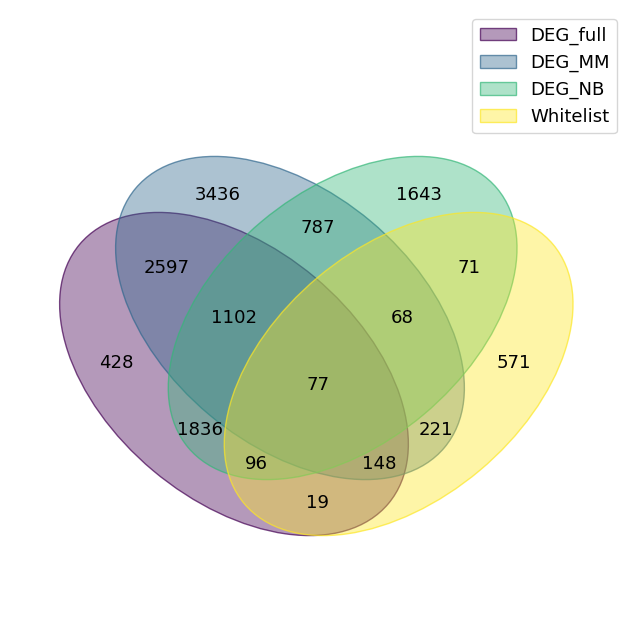

In [19]:
# Get the sets of 'gene_symbol' from each DataFrame
set1 = set(DEG_full['gene_symbol'])
set2 = set(DEG_MM['gene_symbol'])
set3 = set(DEG_NB['gene_symbol'])
set4 = set(whitelist['gene_symbol'])

# Create a dictionary of sets for the Venn diagram
venn_sets = {'DEG_full': set1, 'DEG_MM': set2, 'DEG_NB': set3, 'Whitelist': set4}

# Create the Venn diagram
venn(venn_sets)

plt.show()

## Segmentations

### Exons/5'UTR (SQL)

In [20]:
db_path = "/data/lvisser/Ensembl/ENS_hsa_105.db"
db = sqlite3.connect(db_path)
c = db.cursor()

In [21]:
QUERY = "pragma table_info(gene)"
c.execute(QUERY)
gene_colnames = c.fetchall()
print(gene_colnames)

[(0, 'gene_id', 'INTEGER', 1, None, 1), (1, 'biotype', 'varchar(40)', 1, None, 0), (2, 'analysis_id', 'INTEGER', 1, None, 0), (3, 'seq_region_id', 'INTEGER', 1, None, 0), (4, 'seq_region_start', 'INTEGER', 1, None, 0), (5, 'seq_region_end', 'INTEGER', 1, None, 0), (6, 'seq_region_strand', 'INTEGER', 1, None, 0), (7, 'display_xref_id', 'INTEGER', 0, 'NULL', 0), (8, 'source', 'varchar(40)', 1, None, 0), (9, 'description', 'TEXT', 0, None, 0), (10, 'is_current', 'INTEGER', 1, "'1'", 0), (11, 'canonical_transcript_id', 'INTEGER', 1, None, 0), (12, 'stable_id', 'varchar(128)', 0, 'NULL', 0), (13, 'version', 'INTEGER', 0, 'NULL', 0), (14, 'created_date', 'datetime', 0, 'NULL', 0), (15, 'modified_date', 'datetime', 0, 'NULL', 0)]


In [22]:
QUERY = "select distinct biotype from gene"
c.execute(QUERY)
biotypes = c.fetchall()
print(biotypes)

[('Mt_tRNA',), ('Mt_rRNA',), ('protein_coding',), ('rRNA',), ('lncRNA',), ('processed_pseudogene',), ('snoRNA',), ('polymorphic_pseudogene',), ('unprocessed_pseudogene',), ('transcribed_processed_pseudogene',), ('transcribed_unprocessed_pseudogene',), ('TEC',), ('snRNA',), ('misc_RNA',), ('pseudogene',), ('rRNA_pseudogene',), ('IG_V_pseudogene',), ('TR_V_gene',), ('TR_V_pseudogene',), ('TR_J_gene',), ('TR_C_gene',), ('IG_V_gene',), ('TR_D_gene',), ('unitary_pseudogene',), ('transcribed_unitary_pseudogene',), ('IG_C_gene',), ('IG_D_gene',), ('IG_C_pseudogene',), ('IG_J_gene',), ('IG_J_pseudogene',), ('miRNA',), ('scaRNA',), ('sRNA',), ('TR_J_pseudogene',), ('ribozyme',), ('translated_processed_pseudogene',), ('scRNA',), ('vault_RNA',), ('IG_pseudogene',), ('translated_unprocessed_pseudogene',), ('LRG_gene',)]


In [23]:
QUERY = """
SELECT * 
FROM gene 
JOIN transcript 
ON gene.canonical_transcript_id = transcript.transcript_id 
JOIN exon_transcript 
ON transcript.transcript_id = exon_transcript.transcript_id 
JOIN translation 
ON exon_transcript.transcript_id = translation.transcript_id 
WHERE gene.biotype = 'protein_coding'
"""
c.execute(QUERY)
protein_coding_genes = c.fetchall()
print(protein_coding_genes[0])

# Get column names from cursor description
column_names = [description[0] for description in c.description]

# Write to TSV file
with open('query.tsv', 'w', newline='') as f_output:
    tsv_output = csv.writer(f_output, delimiter='\t')
    tsv_output.writerow(column_names)  # write header
    tsv_output.writerows(protein_coding_genes)  # write data

(559, 'protein_coding', 1, 132907, 3307, 4262, 1, 6375858, 'insdc', 'mitochondrially encoded NADH:ubiquinone oxidoreductase core subunit 1 [Source:HGNC Symbol;Acc:HGNC:7455]', 1, 1592, 'ENSG00000198888', 2, '2004-11-24 00:00:00', '2010-01-08 18:00:56', 1592, 559, 1, 132907, 3307, 4262, 1, 6752818, 'insdc', 'protein_coding', '\\N', 1, 941954, 'ENST00000361390', 2, '2004-11-24 00:00:00', '2010-01-08 18:00:56', 5798, 1592, 1, 941954, 1592, 1, 5798, 956, 5798, 'ENSP00000354687', 2, '2004-11-24 00:00:00', '2010-01-08 18:00:56')


In [24]:
query_df = pd.read_csv('query.tsv', sep='\t')
query_df = query_df.filter(regex='^(?:.+\D|\d+)$')
# query_df = query_df.loc[:, ~query_df.columns.str.endswith('.1')]
print(query_df.shape)
query_df.head()

(233134, 25)


,gene_id,biotype,analysis_id,seq_region_id,seq_region_start,seq_region_end,seq_region_strand,display_xref_id,source,description,...,modified_date,transcript_id,canonical_translation_id,exon_id,rank,translation_id,seq_start,start_exon_id,seq_end,end_exon_id
0,559,protein_coding,1,132907,3307,4262,1,6375858,insdc,mitochondrially encoded NADH:ubiquinone oxidor...,...,2010-01-08 18:00:56,1592,941954,5798,1,941954,1,5798,956,5798
1,564,protein_coding,1,132907,4470,5511,1,6375861,insdc,mitochondrially encoded NADH:ubiquinone oxidor...,...,2010-01-08 18:00:56,1597,941955,5805,1,941955,1,5805,1042,5805
2,572,protein_coding,1,132907,5904,7445,1,6375838,insdc,mitochondrially encoded cytochrome c oxidase I...,...,2010-01-08 18:00:56,1605,941956,5816,1,941956,1,5816,1542,5816
3,575,protein_coding,1,132907,7586,8269,1,6375841,insdc,mitochondrially encoded cytochrome c oxidase I...,...,2004-11-24 00:00:00,1608,941957,5819,1,941957,1,5819,684,5819
4,579,protein_coding,1,132907,8366,8572,1,6375834,insdc,mitochondrially encoded ATP synthase membrane ...,...,2009-05-19 09:47:17,1610,941958,5821,1,941958,1,5821,207,5821


In [25]:
print(query_df.columns)

Index(['gene_id', 'biotype', 'analysis_id', 'seq_region_id',
       'seq_region_start', 'seq_region_end', 'seq_region_strand',
       'display_xref_id', 'source', 'description', 'is_current',
       'canonical_transcript_id', 'stable_id', 'version', 'created_date',
       'modified_date', 'transcript_id', 'canonical_translation_id', 'exon_id',
       'rank', 'translation_id', 'seq_start', 'start_exon_id', 'seq_end',
       'end_exon_id'],
      dtype='object')


### CpG islands (pycoMeth CGI Finder)

In [26]:
cgi_file = "/data/lvisser/segmentations/Homo_sapiens.GRCh38.dna.toplevel.fa.CGI_output.tsv"

cgi_df = pd.read_csv(cgi_file, sep = "\t", dtype={0: str})

cgi_df = cgi_df.loc[cgi_df["length"] > 200, :]
cgi_df["segment_id"] = "chr" + cgi_df['chromosome'].astype(str) + ':' + cgi_df['start'].astype(str) + '-' + cgi_df['end'].astype(str)
cgi_df.to_csv("/data/lvisser/segmentations/cgi_df.csv", index = False)

In [27]:
cgi_df = pd.read_csv("/data/lvisser/segmentations/cgi_df.csv", dtype={0: str})
print(cgi_df.shape)
cgi_df.head()

(383246, 8)


,chromosome,start,end,length,num_CpG,CG_freq,obs_exp_freq,segment_id
0,1,10269,11346,1077,119,0.697,0.912,chr1:10269-11346
1,1,16467,16672,205,8,0.512,0.598,chr1:16467-16672
2,1,26732,26993,261,11,0.540,0.583,chr1:26732-26993
3,1,28623,29844,1221,120,0.695,0.836,chr1:28623-29844
4,1,36785,37058,273,8,0.516,0.518,chr1:36785-37058


### Promotor Regions (Ensembl Regulatory Features GFF)

In [28]:
gff_file = "/data/lvisser/Ensembl/homo_sapiens.GRCh38.Regulatory_Build.regulatory_features.20210107.gff"

rf = gffpd.read_gff3(gff_file)
rf_df = pd.DataFrame(rf.df)

subattributes = rf_df['attributes'].str.split(';', expand=True)

for i in range(subattributes.shape[1]):
    subattribute = subattributes[i].str.split('=', expand=True)
    rf_df[subattribute[0].iloc[0]] = subattribute[1]

rf_df = rf_df.drop('attributes', axis = 1)

rf_df.to_csv('segmentations/all_rf_grch38.csv', index=False)
rf_df.head()

/home/lvisser/miniforge3/envs/jupyterNB/lib/python3.10/site-packages/gffpandas/gffpandas.py:32: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  self.df = pd.read_table(self._gff_file, comment='#',


,seq_id,source,type,start,end,score,strand,phase,ID,bound_end,bound_start,description,feature_type
0,GL000008.2,Regulatory_Build,open_chromatin_region,103733,104006,.,.,.,open_chromatin_region:ENSR00000898744,104006,103733,Open chromatin region,Open chromatin
1,GL000008.2,Regulatory_Build,open_chromatin_region,106249,106503,.,.,.,open_chromatin_region:ENSR00000898745,106503,106249,Open chromatin region,Open chromatin
2,GL000008.2,Regulatory_Build,open_chromatin_region,112878,113287,.,.,.,open_chromatin_region:ENSR00000898746,113287,112878,Open chromatin region,Open chromatin
3,GL000008.2,Regulatory_Build,open_chromatin_region,134012,134308,.,.,.,open_chromatin_region:ENSR00000898747,134308,134012,Open chromatin region,Open chromatin
4,GL000008.2,Regulatory_Build,open_chromatin_region,138112,138274,.,.,.,open_chromatin_region:ENSR00001290160,138274,138112,Open chromatin region,Open chromatin


In [29]:
grch38 = pd.read_csv('/data/lvisser/Ensembl/GRCh38.tsv', sep='\t', header = None)
grch38.columns = ["chrom", "total_length(bp)", "GenBank_accession", "RefSeq_accession"]
grch38.head()

,chrom,total_length(bp),GenBank_accession,RefSeq_accession
0,1,"248,956,422",CM000663.2,NC_000001.11
1,2,"242,193,529",CM000664.2,NC_000002.12
2,3,"198,295,559",CM000665.2,NC_000003.12
3,4,"190,214,555",CM000666.2,NC_000004.12
4,5,"181,538,259",CM000667.2,NC_000005.10


In [30]:
# Replace 'file.sga' with the path to your SGA file
epd_df = pd.read_csv('/data/lvisser/EPD/Hs_EPDnew.sga', sep='\t')
epd_df.columns = ["RefSeq_accession", "type", "position", "strand", "idk", "promotorID"]
epd_df = epd_df.merge(grch38[["chrom", "RefSeq_accession"]], on = "RefSeq_accession", how = "left")
epd_df["gene_symbol"] = epd_df["promotorID"].str.split("_", expand = True)[0]
epd_df["chrom"] = "chr" + epd_df["chrom"].astype(str)

# Print the first few rows of the DataFrame
print(epd_df.shape)
epd_df.head()

(29597, 8)


,RefSeq_accession,type,position,strand,idk,promotorID,chrom,gene_symbol
0,NC_000001.11,TSS,960633,+,1,KLHL17_1,chr1,KLHL17
1,NC_000001.11,TSS,966482,+,1,PLEKHN1_1,chr1,PLEKHN1
2,NC_000001.11,TSS,976681,-,1,PERM1_1,chr1,PERM1
3,NC_000001.11,TSS,1000097,-,1,HES4_1,chr1,HES4
4,NC_000001.11,TSS,1000511,+,1,ISG15_2,chr1,ISG15


In [31]:
rf_promotors = rf_df[rf_df['type'] == 'promoter'].copy()
rf_promotors['seq_id'] = "chr" + rf_promotors['seq_id'].astype(str)
rf_promotors = rf_promotors.rename(columns = {"seq_id": "chrom"})
rf_promotors['segment_id'] = rf_promotors['chrom'].astype(str) + ':' + rf_promotors['start'].astype(str) + '-' + rf_promotors['end'].astype(str)
rf_promotors['region'] = pd.IntervalIndex.from_arrays(rf_promotors['start'], rf_promotors['end'], closed='both')
rf_promotors["length"] = rf_promotors["end"] - rf_promotors["start"]

rf_promotors.to_csv("/data/lvisser/segmentations/rf_promotors_grch38.csv", index=False)

grouped = rf_promotors.groupby('chrom')

# Create an IntervalTree for each group
promotor_trees = {str(seq_id): IntervalTree(Interval(row.start, row.end, row.segment_id) for row in group.itertuples()) for seq_id, group in grouped}

# Convert rf_promotors to a dictionary for faster lookups
rf_promotors_dict = rf_promotors.set_index('segment_id').to_dict('index')

rf_promotors_genes_list = []

for chrom in epd_df["chrom"].unique():
    epd_df_slice = epd_df[epd_df["chrom"] == chrom]
    tree = promotor_trees[chrom]
    for row in epd_df_slice.itertuples():
        intervals = tree[row.position]
        for interval in intervals:
            new_row = rf_promotors_dict[interval.data].copy()
            new_row["segment_id"] = interval.data  # Add 'segment_id' to the new row
            new_row["gene_symbol"] = row.gene_symbol
            rf_promotors_genes_list.append(new_row)

rf_promotors_genes = pd.DataFrame(rf_promotors_genes_list)
rf_promotors_genes = rf_promotors_genes.drop_duplicates()

rf_promotors_genes.to_csv("/data/lvisser/segmentations/rf_promotors_genes.csv", index=False)

In [32]:
rf_promotors_genes = pd.read_csv('/data/lvisser/segmentations/rf_promotors_genes.csv')
print(rf_promotors_genes.shape)
rf_promotors_genes.head()

(16525, 17)


,chrom,source,type,start,end,score,strand,phase,ID,bound_end,bound_start,description,feature_type,region,length,segment_id,gene_symbol
0,chr1,Regulatory_Build,promoter,957600,962001,.,.,.,promoter:ENSR00000000111,963999,956402,Predicted promoter,Promoter,"[957600, 962001]",4401,chr1:957600-962001,KLHL17
1,chr1,Regulatory_Build,promoter,965800,967601,.,.,.,promoter:ENSR00000000112,968199,965402,Predicted promoter,Promoter,"[965800, 967601]",1801,chr1:965800-967601,PLEKHN1
2,chr1,Regulatory_Build,promoter,975600,977201,.,.,.,promoter:ENSR00000344444,978843,975202,Predicted promoter,Promoter,"[975600, 977201]",1601,chr1:975600-977201,PERM1
3,chr1,Regulatory_Build,promoter,997400,1002401,.,.,.,promoter:ENSR00000000118,1007399,995602,Predicted promoter,Promoter,"[997400, 1002401]",5001,chr1:997400-1002401,HES4
4,chr1,Regulatory_Build,promoter,997400,1002401,.,.,.,promoter:ENSR00000000118,1007399,995602,Predicted promoter,Promoter,"[997400, 1002401]",5001,chr1:997400-1002401,ISG15


In [33]:
rf_promotors_DEG = rf_promotors_genes[rf_promotors_genes["gene_symbol"].isin(DEG_full["gene_symbol"])].drop_duplicates()
rf_promotors_DEG.to_csv('/data/lvisser/segmentations/rf_promotors_DEG.csv', index=False)

In [34]:
rf_promotors_DEG = pd.read_csv('/data/lvisser/segmentations/rf_promotors_DEG.csv')
print(rf_promotors_DEG.shape)
rf_promotors_DEG.head()

(4718, 17)


,chrom,source,type,start,end,score,strand,phase,ID,bound_end,bound_start,description,feature_type,region,length,segment_id,gene_symbol
0,chr1,Regulatory_Build,promoter,957600,962001,.,.,.,promoter:ENSR00000000111,963999,956402,Predicted promoter,Promoter,"[957600, 962001]",4401,chr1:957600-962001,KLHL17
1,chr1,Regulatory_Build,promoter,997400,1002401,.,.,.,promoter:ENSR00000000118,1007399,995602,Predicted promoter,Promoter,"[997400, 1002401]",5001,chr1:997400-1002401,HES4
2,chr1,Regulatory_Build,promoter,1173800,1174201,.,.,.,promoter:ENSR00000344517,1174999,1169602,Predicted promoter,Promoter,"[1173800, 1174201]",401,chr1:1173800-1174201,TTLL10
3,chr1,Regulatory_Build,promoter,1204200,1209601,.,.,.,promoter:ENSR00000344533,1210399,1203828,Predicted promoter,Promoter,"[1204200, 1209601]",5401,chr1:1204200-1209601,TNFRSF18
4,chr1,Regulatory_Build,promoter,1211800,1218201,.,.,.,promoter:ENSR00000344538,1218599,1211002,Predicted promoter,Promoter,"[1211800, 1218201]",6401,chr1:1211800-1218201,TNFRSF4


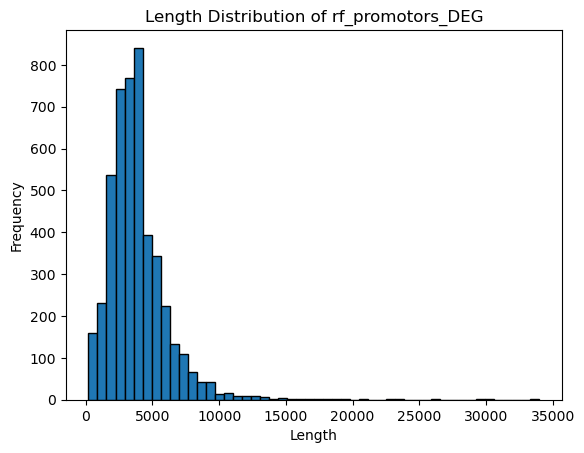

In [35]:
# Assuming 'length' is the column with the lengths
lengths = rf_promotors_DEG['length']

plt.hist(lengths, bins=50, edgecolor='black')
plt.title('Length Distribution of rf_promotors_DEG')
plt.xlabel('Length')
plt.ylabel('Frequency')
plt.show()

### Gene Bodies

In [36]:
gene_bodies_df = pd.read_csv("/data/lvisser/Ensembl/gene_bodies_105.txt", sep = "\t", dtype={6: str})
gene_bodies_df.head()

,Gene stable ID,Gene stable ID version,Transcript stable ID,Transcript stable ID version,Gene start (bp),Gene end (bp),Chromosome/scaffold name,Transcription start site (TSS),Gene name,Gene description
0,ENSG00000210049,ENSG00000210049.1,ENST00000387314,ENST00000387314.1,577,647,MT,577,MT-TF,mitochondrially encoded tRNA-Phe (UUU/C) [Sour...
1,ENSG00000211459,ENSG00000211459.2,ENST00000389680,ENST00000389680.2,648,1601,MT,648,MT-RNR1,mitochondrially encoded 12S rRNA [Source:HGNC ...
2,ENSG00000210077,ENSG00000210077.1,ENST00000387342,ENST00000387342.1,1602,1670,MT,1602,MT-TV,mitochondrially encoded tRNA-Val (GUN) [Source...
3,ENSG00000210082,ENSG00000210082.2,ENST00000387347,ENST00000387347.2,1671,3229,MT,1671,MT-RNR2,mitochondrially encoded 16S rRNA [Source:HGNC ...
4,ENSG00000209082,ENSG00000209082.1,ENST00000386347,ENST00000386347.1,3230,3304,MT,3230,MT-TL1,mitochondrially encoded tRNA-Leu (UUA/G) 1 [So...


In [37]:
gene_bodies_105 = gene_bodies_df[["Gene start (bp)", "Gene end (bp)", "Chromosome/scaffold name", "Gene name"]].copy().dropna()
gene_bodies_105.columns = ["start", "end", "chrom", "gene_symbol"]
gene_bodies_105["chrom"] = "chr" + gene_bodies_105["chrom"]
valid_chromosomes = ['chr' + str(i) for i in range(1, 23)] + ['chrX', 'chrY', 'chrMT']
gene_bodies_105 = gene_bodies_105[gene_bodies_105['chrom'].isin(valid_chromosomes)]
gene_bodies_105["segment_id"] = gene_bodies_105["chrom"] + ":" + gene_bodies_105["start"].astype(str) + "-" + gene_bodies_105["end"].astype(str)
gene_bodies_105["length"] = gene_bodies_105["end"] - gene_bodies_105["start"]
# Remove rows with duplicate 'gene_symbol' values
gene_bodies_105 = gene_bodies_105.drop_duplicates(subset='gene_symbol')
gene_bodies_105.drop_duplicates().to_csv("/data/lvisser/segmentations/gene_bodies_105.csv", index=False)

In [38]:
gene_bodies_105 = pd.read_csv("/data/lvisser/segmentations/gene_bodies_105.csv", dtype={2: str})
print(gene_bodies_105.shape)
gene_bodies_105.head()

(39620, 6)


,start,end,chrom,gene_symbol,segment_id,length
0,577,647,chrMT,MT-TF,chrMT:577-647,70
1,648,1601,chrMT,MT-RNR1,chrMT:648-1601,953
2,1602,1670,chrMT,MT-TV,chrMT:1602-1670,68
3,1671,3229,chrMT,MT-RNR2,chrMT:1671-3229,1558
4,3230,3304,chrMT,MT-TL1,chrMT:3230-3304,74


In [39]:
gene_bodies_DEG = gene_bodies_105[gene_bodies_105["gene_symbol"].isin(DEG_full["gene_symbol"])]
gene_bodies_DEG.to_csv("/data/lvisser/segmentations/gene_bodies_DEG.csv", index=False)

In [40]:
gene_bodies_DEG = pd.read_csv("/data/lvisser/segmentations/gene_bodies_DEG.csv")
print(gene_bodies_DEG.shape)
gene_bodies_DEG.head()

(6302, 6)


,start,end,chrom,gene_symbol,segment_id,length
0,648,1601,chrMT,MT-RNR1,chrMT:648-1601,953
1,1602,1670,chrMT,MT-TV,chrMT:1602-1670,68
2,1671,3229,chrMT,MT-RNR2,chrMT:1671-3229,1558
3,4402,4469,chrMT,MT-TM,chrMT:4402-4469,67
4,5587,5655,chrMT,MT-TA,chrMT:5587-5655,68


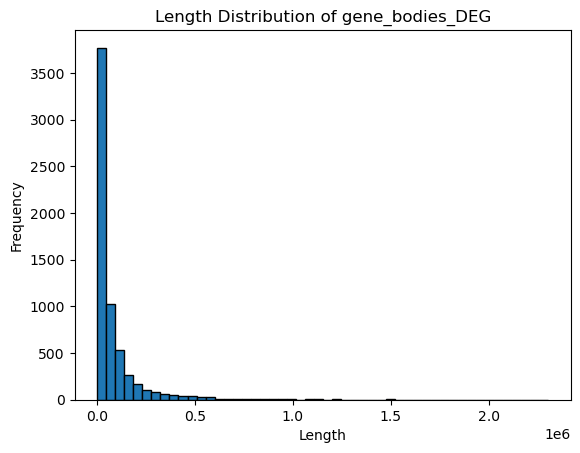

In [41]:
# Assuming 'length' is the column with the lengths
lengths = gene_bodies_DEG['length']

plt.hist(lengths, bins=50, edgecolor='black')
plt.title('Length Distribution of gene_bodies_DEG')
plt.xlabel('Length')
plt.ylabel('Frequency')
plt.show()

### WGBS_tools

In [42]:
# Specify the folder
folder = '/data/lvisser/wgbs_tools/outputs/segmentations/data_OHMX20230016R_20231114/unfiltered'  # replace with your folder

# Find all .bed files in the folder
file_paths = glob.glob(folder + '/**/*.tsv', recursive=True)

# Read each file into a DataFrame and append it to the list, skipping empty files
dfs = []
for i, file_path in enumerate(file_paths):
    try:
        df = pd.read_csv(file_path, sep='\t')
        # Drop columns that are empty or all NA
        df = df.dropna(how='all', axis=1)
        dfs.append(df)
    except pd.errors.EmptyDataError:
        print(f"Skipping empty file: {file_path}")

# Concatenate all DataFrames in the list
wgbs_seg_nb = pd.concat(dfs, ignore_index=True)

# Rename columns with multiple periods to the substring before the first period
wgbs_seg_nb = wgbs_seg_nb.rename(columns=lambda x: x.split('.')[0] if '.' in x else x)

wgbs_seg_nb["segment_id"] = wgbs_seg_nb["chr"].astype(str) + ":" + wgbs_seg_nb["start"].astype(str) + "-" + wgbs_seg_nb["end"].astype(str)

wgbs_seg_nb = wgbs_seg_nb.rename(columns={'chr': 'chrom'})

wgbs_seg_nb.drop(columns = ["start", "end", "chrom", "startCpG", "endCpG"], inplace = True)

wgbs_seg_nb.to_csv("/data/lvisser/feature_matrices/wgbs_seg_nb.csv", index = False)

In [43]:
wgbs_seg_nb = pd.read_csv("/data/lvisser/feature_matrices/wgbs_seg_nb.csv")
print(wgbs_seg_nb.shape)
wgbs_seg_nb.head()

(1895562, 5)


,IMR14nov_R1,SHP12dec_R4,SHY2sept_R1,SKN14nov_R2,segment_id
0,0.88,0.04,0.04,0.06,chr22:10510235-10512049
1,0.92,0.02,0.08,0.07,chr22:10513853-10515736
2,1.00,0.15,0.00,0.00,chr22:10516017-10517750
3,1.00,0.00,0.00,0.09,chr22:10518304-10520219
4,NaN,0.11,0.00,0.06,chr22:10520752-10522650


In [44]:
# Specify the folder
folder = '/data/lvisser/wgbs_tools/outputs/dmr/data_OHMX20230016R_20231114/unfiltered'  # replace with your folder

# Find all .bed files in the folder
file_paths = glob.glob(folder + '/**/*.bed', recursive=True)

# Read each file into a DataFrame and append it to the list, skipping empty files
dfs = []
for i, file_path in enumerate(file_paths):
    try:
        df = pd.read_csv(file_path, sep='\t')
        # Drop columns that are empty or all NA
        df = df.dropna(how='all', axis=1)
        dfs.append(df)
    except pd.errors.EmptyDataError:
        print(f"Skipping empty file: {file_path}")

# Concatenate all DataFrames in the list
wgbs_dmr_nb = pd.concat(dfs, ignore_index=True)

wgbs_dmr_nb = wgbs_dmr_nb.rename(columns={'#chr': 'chrom', 'region': 'segment_id'})

wgbs_dmr_nb.to_csv("/data/lvisser/feature_matrices/wgbs_dmr_nb.csv", index = False)

In [45]:
wgbs_dmr_nb = pd.read_csv("/data/lvisser/feature_matrices/wgbs_dmr_nb.csv")
print(wgbs_dmr_nb.shape)
wgbs_dmr_nb.head()

(37200, 16)


,chrom,start,end,startCpG,endCpG,target,segment_id,lenCpG,bp,tg_mean,bg_mean,delta_means,delta_quants,delta_maxmin,ttest,direction
0,chr8,339324,339424,12448810,12448816,R,chr8:339324-339424,6CpGs,100bp,0.1650,0.746,0.581,0.457,0.404,0.0442,U
1,chr8,636727,636822,12453158,12453162,R,chr8:636727-636822,4CpGs,95bp,0.3810,0.882,0.501,0.471,0.446,0.0091,U
2,chr8,1373259,1373562,12470337,12470371,R,chr8:1373259-1373562,34CpGs,303bp,0.0185,0.813,0.794,0.707,0.693,0.0111,U
3,chr8,1956798,1957098,12483994,12484007,R,chr8:1956798-1957098,13CpGs,300bp,0.1170,0.909,0.792,0.684,0.658,0.0157,U
4,chr8,1958036,1958341,12484025,12484039,R,chr8:1958036-1958341,14CpGs,305bp,0.0329,0.607,0.574,0.503,0.499,0.0160,U


## Feature Extraction/Reduction

### Annotation-Based

#### Promotor Regions

In [123]:
cpg_promotors_df_1 = pd.read_csv("/data/lvisser/feature_matrices/concatenated_tables/data_OHMX20230016R_20231114/cpg_cat_nb1_scvg.csv")
cpg_promotors_df_2 = pd.read_csv("/data/lvisser/feature_matrices/concatenated_tables/data_OHMX20230016R_MM_2/cpg_cat_mm1_scvg.csv")
cpg_promotors_df = pd.concat([cpg_promotors_df_1, cpg_promotors_df_2])
print(cpg_promotors_df.shape)
cpg_promotors_df.head()

(37703326, 6)


,source_directory,sample_id_adj,ref_position,chrom,position_coverage,mod_qual
0,data_OHMX20230016R_20231114,IMR14nov_R1,17000252,chr15,4,0.996582
1,data_OHMX20230016R_20231114,IMR14nov_R1,17000408,chr15,9,0.885525
2,data_OHMX20230016R_20231114,IMR14nov_R1,17000409,chr15,11,0.988370
3,data_OHMX20230016R_20231114,IMR14nov_R1,17000423,chr15,10,0.947266
4,data_OHMX20230016R_20231114,IMR14nov_R1,17000424,chr15,16,0.960938


In [133]:
rf_promotors_DEG = pd.read_csv("/data/lvisser/segmentations/rf_promotors_DEG.csv")
meth_seg_promotors = cpg2segment_aggregation_trees(cpg_promotors_df, rf_promotors_DEG[["chrom", "start", "end", "segment_id", "gene_symbol", "length"]].copy())
meth_seg_promotors.to_csv("/data/lvisser/feature_matrices/meth_seg_promotors.csv", index = False)

initializing meth_seg...


Aggregating: 100%|██████████| 184/184 [16:45<00:00,  5.46s/it]


In [134]:
meth_seg_promotors = pd.read_csv("/data/lvisser/feature_matrices/meth_seg_promotors.csv")
meth_seg_promotors['positions'] = meth_seg_promotors['positions'].apply(ast.literal_eval)
meth_seg_promotors['mod_qual_positions'] = meth_seg_promotors['mod_qual_positions'].apply(ast.literal_eval)
print(meth_seg_promotors.shape)
meth_seg_promotors.head()

(37744, 11)


,sample_id_adj,segment_id,source_directory,total_methylation,positions,mod_qual_positions,num_cpgs,avg_methylation,gene_symbol,length,chrom
0,IMR14nov_R1,chr10:100183600-100187801,data_OHMX20230016R_20231114,58.504949,"[100183623, 100183624, 100183770, 100184066, 1...","[0.020507813, 0.2193359354, 0.0216796879, 0.97...",193,0.303134,ERLIN1,4201,chr10
1,MM1R_4_3,chr10:100183600-100187801,data_OHMX20230016R_MM_2,55.215416,"[100183623, 100183624, 100183770, 100183771, 1...","[0.3483072878333333, 0.269042967875, 0.8003906...",181,0.305058,ERLIN1,4201,chr10
2,JJN3_2_1,chr10:100183600-100187801,data_OHMX20230016R_MM_2,34.831982,"[100183623, 100183624, 100183770, 100183771, 1...","[0.4393136202857142, 0.6072265617, 0.629394526...",155,0.224722,ERLIN1,4201,chr10
3,SKN14nov_R2,chr10:100183600-100187801,data_OHMX20230016R_20231114,37.765207,"[100183623, 100183624, 100183770, 100183771, 1...","[0.754394533875, 0.6752387115555556, 0.8609095...",185,0.204136,ERLIN1,4201,chr10
4,RPMI8226_3_3,chr10:100183600-100187801,data_OHMX20230016R_MM_2,23.476271,"[100183623, 100183770, 100184066, 100184114, 1...","[0.6713324603888888, 0.869140619125, 0.8264973...",97,0.242023,ERLIN1,4201,chr10


In [135]:
meth_seg_promotors_fm = create_fm(meth_seg_promotors, metadata)
meth_seg_promotors_fm.to_csv("/data/lvisser/feature_matrices/meth_seg_promotors_fm.csv", index = False)

In [136]:
meth_seg_promotors_fm = pd.read_csv("/data/lvisser/feature_matrices/meth_seg_promotors_fm.csv")
print(meth_seg_promotors_fm.shape)
meth_seg_promotors_fm.head()

(8, 4564)


,Group,sample_id_adj,source_directory,chr10:100183600-100187801,chr10:100266000-100268800,chr10:100284600-100287601,chr10:100345600-100351401,chr10:100745000-100746201,chr10:100968800-100972001,chr10:101775800-101776601,...,chrX:75273001-75276601,chrX:78138400-78140400,chrX:79362601-79368401,chrX:80807000-80811401,chrX:85375201-85380000,chrX:8729800-8732801,chrX:87517000-87521200,chrX:9462800-9468201,chrX:9785000-9788401,chrX:9912200-9915000
0,S,IMR14nov_R1,data_OHMX20230016R_20231114,0.303134,0.073730,0.397803,0.224065,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000
1,S,SHP12dec_R4,data_OHMX20230016R_20231114,0.304761,0.657416,0.000000,0.226532,0.000000,0.000000,0.0,...,0.000000,0.709147,0.000000,0.038086,0.0,0.985352,0.000000,0.055664,0.0,0.000000
2,R,SHY2sept_R1,data_OHMX20230016R_20231114,0.307762,0.000000,0.919556,0.267479,0.000000,0.188477,0.0,...,0.000000,0.000000,0.192505,0.000000,0.0,0.000000,0.000000,0.189453,0.0,0.049072
3,R,SKN14nov_R2,data_OHMX20230016R_20231114,0.204136,0.000000,0.705543,0.209788,0.000000,0.000000,0.0,...,0.948242,0.547461,0.000000,0.000000,0.0,0.000000,0.592187,0.123798,0.0,0.000000
4,R,JJN3_2_1,data_OHMX20230016R_MM_2,0.224722,0.000000,0.000000,0.226924,0.161051,0.256836,0.0,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000


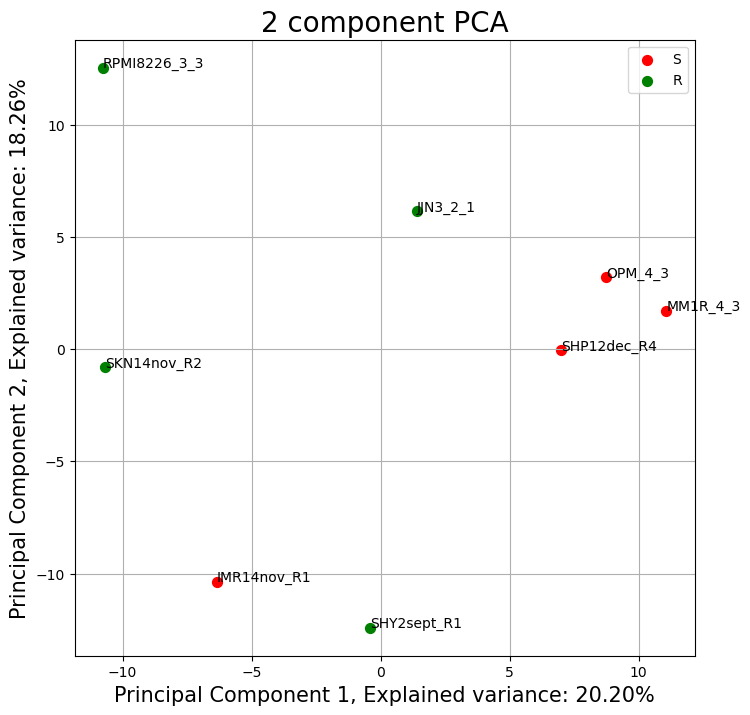

In [137]:
pca_plot(meth_seg_promotors_fm, n_components=2, group_column="Group", label_column = "sample_id_adj")

#### Gene Bodies

In [143]:
cpg_genebds_df_1 = pd.read_csv("/data/lvisser/feature_matrices/concatenated_tables/data_OHMX20230016R_20231114/cpg_cat_nb1_scvg.csv")
cpg_genebds_df_2 = pd.read_csv("/data/lvisser/feature_matrices/concatenated_tables/data_OHMX20230016R_MM_2/cpg_cat_mm1_scvg.csv")
cpg_genebds_df = pd.concat([cpg_genebds_df_1, cpg_genebds_df_2])
print(cpg_genebds_df.shape)
cpg_genebds_df.head()

(37703326, 6)


,source_directory,sample_id_adj,ref_position,chrom,position_coverage,mod_qual
0,data_OHMX20230016R_20231114,IMR14nov_R1,17000252,chr15,4,0.996582
1,data_OHMX20230016R_20231114,IMR14nov_R1,17000408,chr15,9,0.885525
2,data_OHMX20230016R_20231114,IMR14nov_R1,17000409,chr15,11,0.988370
3,data_OHMX20230016R_20231114,IMR14nov_R1,17000423,chr15,10,0.947266
4,data_OHMX20230016R_20231114,IMR14nov_R1,17000424,chr15,16,0.960938


In [144]:
gene_bodies_DEG = pd.read_csv("/data/lvisser/segmentations/gene_bodies_DEG.csv")
meth_seg_genebds = cpg2segment_aggregation_trees(cpg_genebds_df, gene_bodies_DEG[["chrom", "start", "end", "segment_id", "gene_symbol", "length"]].copy())
meth_seg_genebds.to_csv("/data/lvisser/feature_matrices/meth_seg_genebds.csv", index = False)

initializing meth_seg...


Aggregating: 100%|██████████| 200/200 [32:15<00:00,  9.68s/it]


In [46]:
meth_seg_genebds = pd.read_csv("/data/lvisser/feature_matrices/meth_seg_genebds.csv")
meth_seg_genebds['positions'] = meth_seg_genebds['positions'].apply(ast.literal_eval)
meth_seg_genebds['mod_qual_positions'] = meth_seg_genebds['mod_qual_positions'].apply(ast.literal_eval)
print(meth_seg_genebds.shape)
meth_seg_genebds.head()

(50416, 11)


,sample_id_adj,segment_id,source_directory,total_methylation,positions,mod_qual_positions,num_cpgs,avg_methylation,gene_symbol,length,chrom
0,SKN14nov_R2,chr10:100150094-100186033,data_OHMX20230016R_20231114,232.315618,"[100150292, 100150316, 100150440, 100153977, 1...","[0.890625, 0.976562495, 0.9921875, 0.984375005...",319,0.728262,ERLIN1,35939,chr10
1,SHY2sept_R1,chr10:100150094-100186033,data_OHMX20230016R_20231114,271.473594,"[100150200, 100150207, 100150292, 100150316, 1...","[0.987304684, 0.99804687, 0.99218751, 0.980468...",370,0.733712,ERLIN1,35939,chr10
2,SHP12dec_R4,chr10:100150094-100186033,data_OHMX20230016R_20231114,118.588156,"[100154669, 100154820, 100154911, 100154921, 1...","[0.993164068, 0.7599609376, 0.99169922, 0.9946...",184,0.644501,ERLIN1,35939,chr10
3,IMR14nov_R1,chr10:100150094-100186033,data_OHMX20230016R_20231114,230.656383,"[100150207, 100150292, 100150316, 100150440, 1...","[0.993598088888889, 0.9881417457142856, 0.9478...",320,0.720801,ERLIN1,35939,chr10
4,RPMI8226_3_3,chr10:100150094-100186033,data_OHMX20230016R_MM_2,78.781387,"[100168667, 100168764, 100168781, 100168827, 1...","[0.993554692, 0.964257812, 0.993554688, 0.8751...",116,0.679150,ERLIN1,35939,chr10


In [149]:
meth_seg_genebds_fm = create_fm(meth_seg_genebds, metadata)
meth_seg_genebds_fm.to_csv("/data/lvisser/feature_matrices/meth_seg_genebds_fm.csv", index = False)

In [72]:
meth_seg_genebds_fm = pd.read_csv("/data/lvisser/feature_matrices/meth_seg_genebds_fm.csv")
print(meth_seg_genebds_fm.shape)
meth_seg_genebds_fm.head()

(8, 6305)


,Group,sample_id_adj,source_directory,chr10:100150094-100186033,chr10:100232298-100267680,chr10:100273280-100286680,chr10:100347233-100364826,chr10:100463009-100483744,chr10:100735396-100829944,chr10:100969518-100985871,...,chrX:91779261-92623230,chrX:92113246-92114461,chrX:93670930-93673578,chrX:9463320-9741037,chrX:95973328-95974315,chrX:9786429-9949443,chrY:11957208-11987386,chrY:14522573-14845654,chrY:5337745-5338964,chrY:7341531-7341642
0,S,IMR14nov_R1,data_OHMX20230016R_20231114,0.720801,0.938771,0.755933,0.725153,0.472495,0.542559,0.866641,...,0.772078,0.000000,0.0,0.930664,0.0,0.910590,0.0,0.989607,0.0,0.0
1,S,SHP12dec_R4,data_OHMX20230016R_20231114,0.644501,0.940385,0.950664,0.671316,0.445223,0.400360,0.000000,...,0.194387,0.000000,0.0,0.602164,0.0,0.863387,0.0,0.000000,0.0,0.0
2,R,SHY2sept_R1,data_OHMX20230016R_20231114,0.733712,0.948580,0.871512,0.683673,0.608161,0.938165,0.765363,...,0.165945,0.050293,0.0,0.655635,0.0,0.418713,0.0,0.000000,0.0,0.0
3,R,SKN14nov_R2,data_OHMX20230016R_20231114,0.728262,0.938848,0.832533,0.626813,0.361640,0.542832,0.000000,...,0.423311,0.000000,0.0,0.805574,0.0,0.506181,0.0,0.000000,0.0,0.0
4,R,JJN3_2_1,data_OHMX20230016R_MM_2,0.613701,0.888365,0.877064,0.648939,0.266180,0.226052,0.774888,...,0.479948,0.000000,0.0,0.000000,0.0,0.669510,0.0,0.000000,0.0,0.0


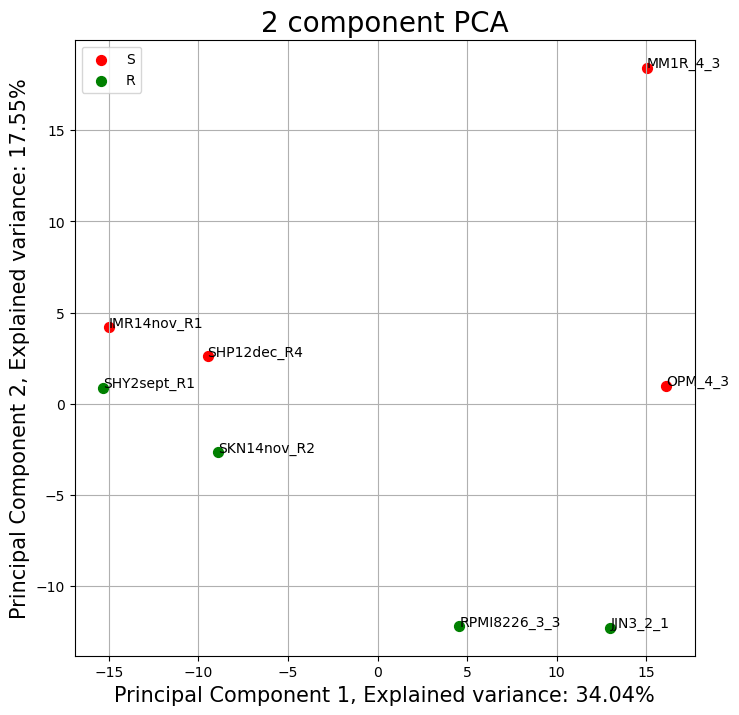

In [151]:
pca_plot(meth_seg_genebds_fm, n_components=2, group_column="Group", label_column = "sample_id_adj")

#### Correlation Transcription-Methylation

In [142]:
tm_pcc(meth_seg_promotors, metadata, DEG_full, "tm_pcc_promotors.csv")

Average pearson correlation: 0.0811528646718115
Average p-value: 9.101746641040641e-36


100%|██████████| 23590/23590 [01:24<00:00, 278.47it/s] 


,gene,p_value,pearson
562,IRS2,0.000000e+00,-0.441399
801,HBQ1,0.000000e+00,-0.823020
3097,GNAQ,1.393870e-281,-0.600706
1168,APC2,2.835850e-181,-0.459795
1552,TGFB2,2.143957e-174,-0.597280


In [55]:
tm_pcc(meth_seg_genebds, metadata, DEG_full, "tm_pcc_genebds.csv")

Average methylation - log2counts pearson correlation: 0.38368899225104414
p-value: 0.0
Total methylation - log2counts pearson correlation: 0.15637944094621514
p-value: 4.859150810995496e-172


<function __main__.tm_pcc(meth_seg, metadata, DEG_full, pcc_file)>

### Annotation-Agnostic

#### DBSCAN cluster segmentation

In [121]:
cpg_dbscan_df_1 = pd.read_csv("/data/lvisser/feature_matrices/concatenated_tables/data_OHMX20230016R_20231114/cpg_cat_nb1_unicvg.csv")
cpg_dbscan_df_2 = pd.read_csv("/data/lvisser/feature_matrices/concatenated_tables/data_OHMX20230016R_MM_2/cpg_cat_mm1_unicvg.csv")

# Get the unique 'ref_positions' present in both DataFrames
common_ref_positions = set(cpg_dbscan_df_1['ref_position'].unique()).intersection(cpg_dbscan_df_2['ref_position'].unique())

# Filter both DataFrames to only include the common 'ref_positions'
cpg_dbscan_df_1_filtered = cpg_dbscan_df_1[cpg_dbscan_df_1['ref_position'].isin(common_ref_positions)]
cpg_dbscan_df_2_filtered = cpg_dbscan_df_2[cpg_dbscan_df_2['ref_position'].isin(common_ref_positions)]

# Concatenate the filtered DataFrames
cpg_dbscan_df = pd.concat([cpg_dbscan_df_1_filtered, cpg_dbscan_df_2_filtered])
print(cpg_dbscan_df.shape)
cpg_dbscan_df.head()

(42796636, 7)


,source_directory,sample_id_adj,ref_position,chrom,position_coverage,mod_qual,unique_samples
8,data_OHMX20230016R_20231114,IMR14nov_R1,17000538,chr15,9,0.995551,4
17,data_OHMX20230016R_20231114,IMR14nov_R1,17000898,chr15,20,0.405273,4
27,data_OHMX20230016R_20231114,IMR14nov_R1,17005585,chr15,1,0.036133,4
28,data_OHMX20230016R_20231114,IMR14nov_R1,17005859,chr15,1,0.995117,4
43,data_OHMX20230016R_20231114,IMR14nov_R1,17015723,chr15,1,0.028320,4


In [129]:
# Initialize the LabelEncoder
le = LabelEncoder()

# Initialize an empty DataFrame to store the results
cluster_dbscan_df = pd.DataFrame()

scores = []

best_params = {}

# Define the parameter values that should be searched
eps_values = [3]
min_samples_values = [3]

# Group the DataFrame by 'chrom'
grouped = cpg_dbscan_df.groupby('chrom')

# For each group (i.e., each chromosome), perform DBSCAN clustering
for chrom, group in grouped:
    print(f"Processing chromosome: {chrom}")

    # Get every unique 'ref_position'
    df = group[['ref_position']].drop_duplicates().reset_index(drop=True).sort_values('ref_position')

    # Reshape 'ref_position' to 2D array for the fit method
    X = df['ref_position'].values.reshape(-1, 1)

    # Initialize variables to store the best parameters and the best silhouette score
    best_eps = None
    best_min_samples = None

    # Validate the parameters
    # best_eps, best_min_samples, best_score = validate_parameters(X, eps_values, min_samples_values)

    best_eps = eps_values[0]
    best_min_samples = min_samples_values[0]

    # Apply DBSCAN
    db = DBSCAN(eps = best_eps, min_samples=best_min_samples, n_jobs = 8).fit(X)  # adjust parameters as needed

    # Add cluster labels, chromosome, start and end positions to the DataFrame
    df['cluster'] = db.labels_
    df['chrom'] = chrom
    df['start'] = df.groupby('cluster')['ref_position'].transform('min')
    df['end'] = df.groupby('cluster')['ref_position'].transform('max')
    df['length'] = df['end'] - df['start'] + 1
    df['segment_id'] = df['chrom'].astype(str) + ':' + df['start'].astype(str) + '-' + df['end'].astype(str)

    # Add a column for the number of CpGs in each cluster
    df['num_cpgs'] = df.groupby('segment_id')['ref_position'].transform('count')

    # Create a new column for CpG saturation
    df['cpg_saturation'] = df['num_cpgs'] / df['length']

    # Filter out rows where the cluster label is -1
    df = df[df['cluster'] != -1]

    # Append the results to the results DataFrame
    cluster_dbscan_df = pd.concat([cluster_dbscan_df, df])

# Write the results to a CSV file
cluster_dbscan_df.to_csv("/data/lvisser/segmentations/cluster_dbscan_df.csv", index=False)

Processing chromosome: chr1
Processing chromosome: chr10
Processing chromosome: chr11
Processing chromosome: chr12
Processing chromosome: chr13
Processing chromosome: chr14
Processing chromosome: chr15
Processing chromosome: chr16
Processing chromosome: chr17
Processing chromosome: chr18
Processing chromosome: chr19
Processing chromosome: chr2
Processing chromosome: chr20
Processing chromosome: chr21
Processing chromosome: chr22
Processing chromosome: chr3
Processing chromosome: chr4
Processing chromosome: chr5
Processing chromosome: chr6
Processing chromosome: chr7
Processing chromosome: chr8
Processing chromosome: chr9
Processing chromosome: chrMT
Processing chromosome: chrX
Processing chromosome: chrY


In [130]:
cluster_dbscan_df = pd.read_csv("/data/lvisser/segmentations/cluster_dbscan_df.csv")
print(cluster_dbscan_df.shape)
cluster_dbscan_df.head()

(609449, 9)


,ref_position,cluster,chrom,start,end,length,segment_id,num_cpgs,cpg_saturation
0,10576,0,chr1,10576,10578,3,chr1:10576-10578,3,1.000000
1,10577,0,chr1,10576,10578,3,chr1:10576-10578,3,1.000000
2,10578,0,chr1,10576,10578,3,chr1:10576-10578,3,1.000000
3,10616,1,chr1,10616,10622,7,chr1:10616-10622,3,0.428571
4,10619,1,chr1,10616,10622,7,chr1:10616-10622,3,0.428571


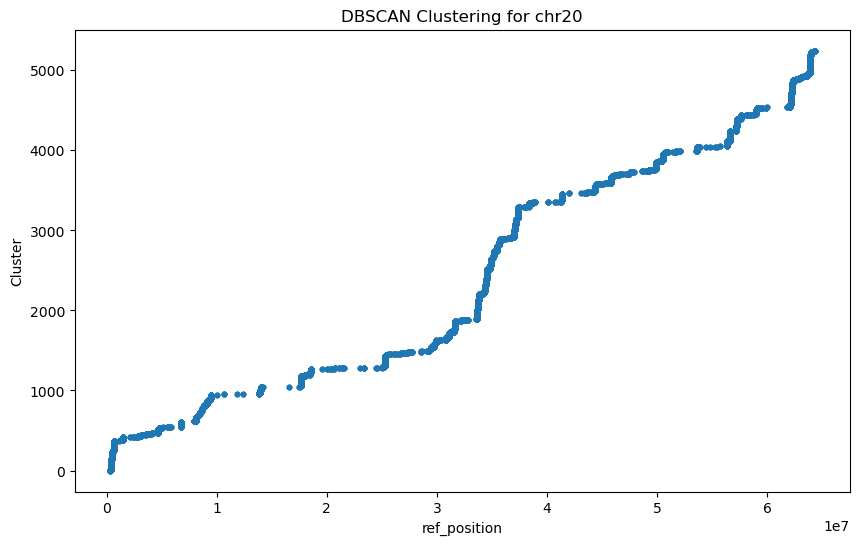

In [131]:
def plot_clusters_for_chromosome(cluster_dbscan_df, chromosome, covered_positions = None):
    # Filter the DataFrame for the specified chromosome
    df = cluster_dbscan_df[cluster_dbscan_df['chrom'] == chromosome]

    # Create a scatter plot
    fig, ax = plt.subplots(figsize=(10, 6))

    if covered_positions is not None:
        # Add vertical strips for covered_positions with reduced alpha
        for pos in covered_positions:
            ax.axvspan(pos, pos+1, color='red', alpha=0.1)

    # Scatter plot for cluster_df
    ax.scatter(df['ref_position'], df['cluster'], s=10)

    ax.set_title(f'DBSCAN Clustering for {chromosome}')
    ax.set_xlabel('ref_position')
    ax.set_ylabel('Cluster')

    plt.show()

# Call the function for a specific chromosome
chrom = 'chr20'
covered_positions = cpg_dbscan_df["ref_position"][cpg_dbscan_df["chrom"] == chrom]
plot_clusters_for_chromosome(cluster_dbscan_df, chrom)

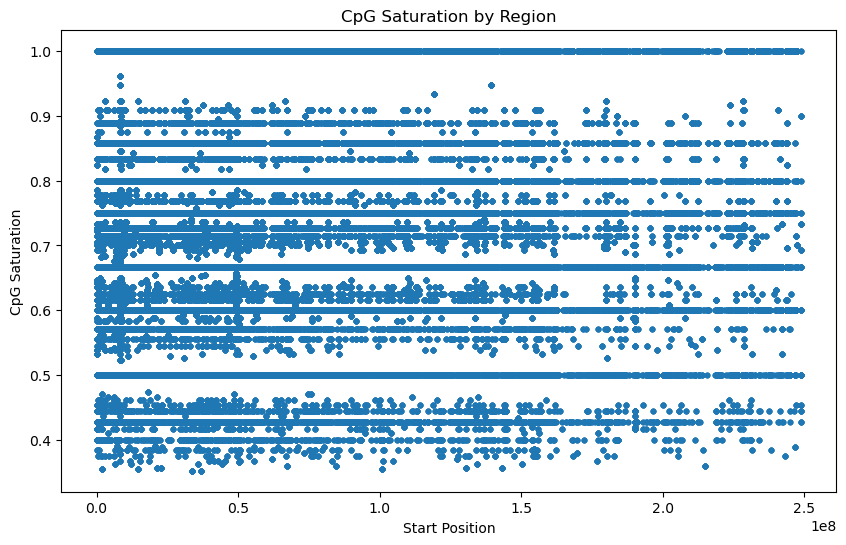

In [132]:
# Plot the CpG saturation
plt.figure(figsize=(10, 6))
plt.scatter(cluster_dbscan_df['start'], cluster_dbscan_df['cpg_saturation'], s=10)
plt.title('CpG Saturation by Region')
plt.xlabel('Start Position')
plt.ylabel('CpG Saturation')
plt.show()

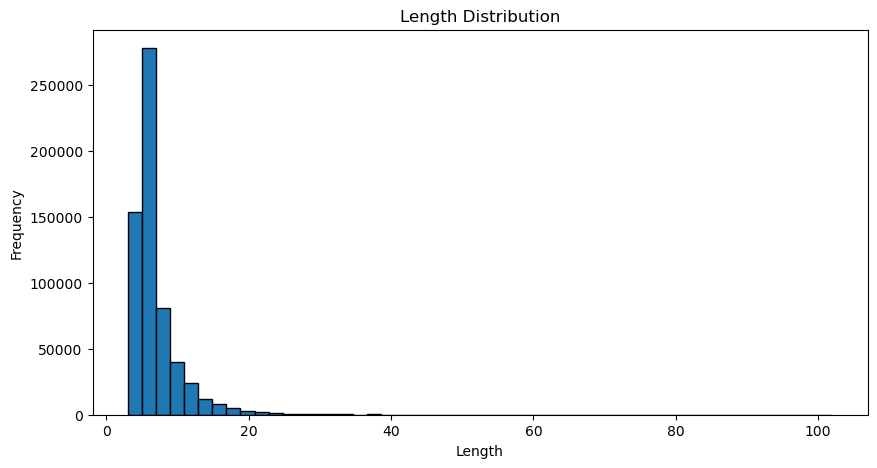

In [133]:
# Create the plot
plt.figure(figsize=(10, 5))
plt.hist(cluster_dbscan_df['length'], bins=50, edgecolor='black')  # Adjust the number of bins to your needs
plt.xlabel('Length')
plt.ylabel('Frequency')
plt.title('Length Distribution')
plt.show()

In [170]:
# Merge 'segment_id' from cluster_df into meth_seg
meth_seg_dbscan = cpg_dbscan_df.merge(cluster_dbscan_df[['chrom', 'ref_position', 'segment_id']], how='inner', on=['chrom', 'ref_position'])
meth_seg_dbscan = meth_seg_dbscan.merge(metadata[["sample_id_adj", "Group"]], on = "sample_id_adj", how = "left").drop_duplicates().reset_index(drop = True)
meth_seg_dbscan['avg_methylation'] = meth_seg_dbscan.groupby(["segment_id", "sample_id_adj", "source_directory"])['mod_qual'].transform('mean')

# Add a column for the variance of 'mod_qual' within each 'segment_id'
meth_seg_dbscan['var_methylation'] = meth_seg_dbscan.groupby(["segment_id", "sample_id_adj", "source_directory"])['mod_qual'].transform('var')

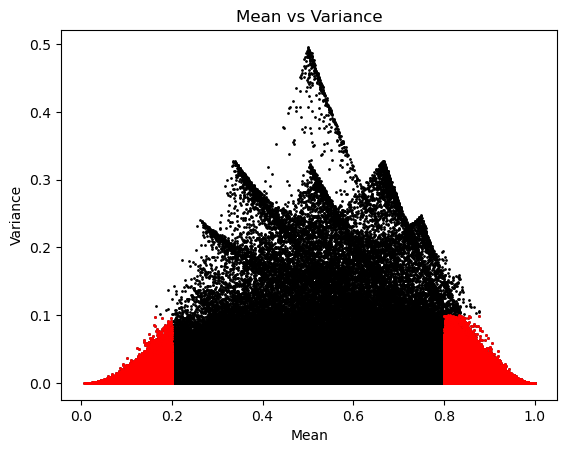

In [171]:
# Drop duplicates based on 'entropy' and 'mod_qual_variance'
unique_combinations = meth_seg_dbscan[['avg_methylation', 'var_methylation']].drop_duplicates()

# Create a boolean mask for the points to highlight
mask = (unique_combinations['var_methylation'] < 0.1) & ((unique_combinations['avg_methylation'] > 0.8) | (unique_combinations['avg_methylation'] < 0.2))

# Plot all points with smaller size and lighter color
plt.scatter(unique_combinations['avg_methylation'], unique_combinations['var_methylation'], s=1, color='black')

# Plot highlighted points with larger size and darker color
plt.scatter(unique_combinations['avg_methylation'][mask], unique_combinations['var_methylation'][mask], s=1, color='red')

plt.title('Mean vs Variance')
plt.xlabel('Mean')
plt.ylabel('Variance')
plt.show()

In [172]:
# Define a function that checks if all samples in a group fulfill the requirements
def check_requirements(group):
    return (group['var_methylation'] < 0.1).all() and ((group['avg_methylation'] > 0.8) | (group['avg_methylation'] < 0.2)).all()

# Apply the function to each group
requirements_fulfilled = meth_seg_dbscan.groupby('segment_id').apply(check_requirements, include_groups=False)

# Get the 'segment_id' values for which all samples fulfill the requirements
segment_ids_to_keep = requirements_fulfilled[requirements_fulfilled].index

# Filter the DataFrame to only include these 'segment_id' values
meth_seg_dbscan = meth_seg_dbscan[meth_seg_dbscan['segment_id'].isin(segment_ids_to_keep)]
# Save the DataFrame to a CSV file
meth_seg_dbscan.to_csv("/data/lvisser/feature_matrices/meth_seg_dbscan.csv", index = False)

/tmp/ipykernel_34641/4152029304.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  requirements_fulfilled = meth_seg_dbscan.groupby('segment_id').apply(check_requirements)


In [173]:
meth_seg_dbscan = pd.read_csv("/data/lvisser/feature_matrices/meth_seg_dbscan.csv")
print(meth_seg_dbscan.shape)
meth_seg_dbscan.head()

(1731016, 11)


,source_directory,sample_id_adj,ref_position,chrom,position_coverage,mod_qual,unique_samples,segment_id,Group,avg_methylation,var_methylation
0,data_OHMX20230016R_20231114,IMR14nov_R1,20358748,chr15,2,0.962891,4,chr15:20358748-20358752,S,0.96582,0.000401
1,data_OHMX20230016R_20231114,IMR14nov_R1,20358749,chr15,2,0.939453,4,chr15:20358748-20358752,S,0.96582,0.000401
2,data_OHMX20230016R_20231114,IMR14nov_R1,20358751,chr15,2,0.974609,4,chr15:20358748-20358752,S,0.96582,0.000401
3,data_OHMX20230016R_20231114,IMR14nov_R1,20358752,chr15,2,0.986328,4,chr15:20358748-20358752,S,0.96582,0.000401
4,data_OHMX20230016R_20231114,IMR14nov_R1,23175156,chr15,1,0.948242,4,chr15:23175156-23175160,S,0.97168,0.000404


In [174]:
meth_seg_dbscan_fm = create_fm(meth_seg_dbscan, metadata)
meth_seg_dbscan_fm.to_csv("/data/lvisser/feature_matrices/meth_seg_dbscan_fm.csv", index = False)

In [175]:
meth_seg_dbscan_fm = pd.read_csv("/data/lvisser/feature_matrices/meth_seg_dbscan_fm.csv")
print(meth_seg_dbscan_fm.shape)
meth_seg_dbscan_fm.head()

(8, 51839)


,Group,sample_id_adj,source_directory,chr10:100176847-100176850,chr10:100180609-100180614,chr10:100181804-100181809,chr10:100182320-100182324,chr10:100185420-100185425,chr10:100185927-100185930,chr10:100186139-100186142,...,chrX:70444748-70444754,chrX:72877162-72877165,chrX:77831074-77831079,chrX:77885391-77885395,chrX:77903435-77903440,chrX:77903992-77903995,chrX:77904222-77904227,chrX:77909396-77909401,chrX:77914545-77914548,chrY:11297756-11297759
0,S,IMR14nov_R1,data_OHMX20230016R_20231114,0.913181,0.914562,0.983968,0.922819,0.110091,0.178540,0.123991,...,0.109049,0.987956,0.976237,0.956868,0.987444,0.952881,0.973307,0.994954,0.944196,0.128150
1,R,JJN3_2_1,data_OHMX20230016R_MM_2,0.933582,0.984029,0.969227,0.947469,0.132080,0.139221,0.142335,...,0.138346,0.989258,0.984701,0.975152,0.902832,0.976644,0.896973,0.879639,0.977539,0.091887
2,S,MM1R_4_3,data_OHMX20230016R_MM_2,0.931266,0.972399,0.981533,0.932043,0.138777,0.151150,0.148934,...,0.122721,0.988770,0.989909,0.930664,0.940839,0.901857,0.867488,0.964657,0.931547,0.101943
3,S,OPM_4_3,data_OHMX20230016R_MM_2,0.930729,0.988281,0.950842,0.938672,0.112478,0.174655,0.149095,...,0.144206,0.059570,0.940430,0.906876,0.960151,0.949032,0.873284,0.985271,0.902007,0.048625
4,R,RPMI8226_3_3,data_OHMX20230016R_MM_2,0.949316,0.967611,0.949037,0.967876,0.109375,0.165747,0.150675,...,0.992296,0.047852,0.995117,0.956163,0.978353,0.909790,0.962728,0.996338,0.973999,0.073719


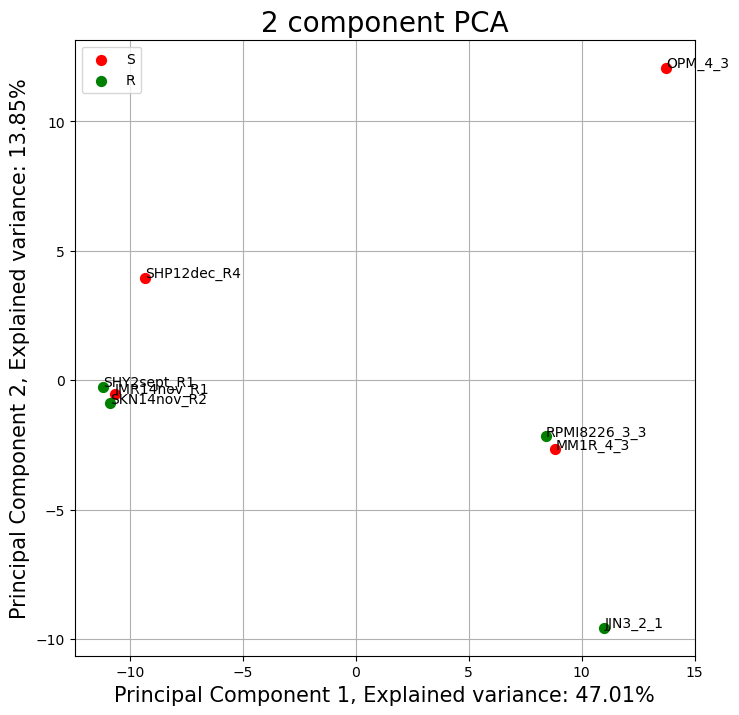

In [176]:
pca_plot(meth_seg_dbscan_fm, n_components=2, group_column="Group", label_column = "sample_id_adj")

#### WGBS_tools

In [178]:
cpg_wgbstools_test_df = pd.read_csv("/data/lvisser/feature_matrices/concatenated_tables/data_OHMX20230016R_MM_2/cpg_cat_mm1_scvg.csv")
print(cpg_wgbstools_test_df.shape)
cpg_wgbstools_test_df.head()

(15372605, 6)


,source_directory,sample_id_adj,ref_position,chrom,position_coverage,mod_qual
0,data_OHMX20230016R_MM_2,MM1R_4_3,10880,chr16,5,0.453711
1,data_OHMX20230016R_MM_2,MM1R_4_3,23643,chr16,5,0.773633
2,data_OHMX20230016R_MM_2,MM1R_4_3,23648,chr16,5,0.615039
3,data_OHMX20230016R_MM_2,MM1R_4_3,50563,chr16,5,0.968945
4,data_OHMX20230016R_MM_2,MM1R_4_3,50802,chr16,5,0.949805


In [185]:
wgbs_seg_train = pd.read_csv("/data/lvisser/feature_matrices/wgbs_seg_nb.csv")
print(wgbs_seg_train.shape)
wgbs_seg_train.head()

(1895562, 5)


,IMR14nov_R1,SHP12dec_R4,SHY2sept_R1,SKN14nov_R2,segment_id
0,0.88,0.04,0.04,0.06,chr22:10510235-10512049
1,0.92,0.02,0.08,0.07,chr22:10513853-10515736
2,1.00,0.15,0.00,0.00,chr22:10516017-10517750
3,1.00,0.00,0.00,0.09,chr22:10518304-10520219
4,NaN,0.11,0.00,0.06,chr22:10520752-10522650


In [181]:
wgbs_dmr_train = pd.read_csv("/data/lvisser/feature_matrices/wgbs_dmr_nb.csv")
print(wgbs_dmr_train.shape)
wgbs_dmr_train.head()

(37200, 16)


,chrom,start,end,startCpG,endCpG,target,segment_id,lenCpG,bp,tg_mean,bg_mean,delta_means,delta_quants,delta_maxmin,ttest,direction
0,chr8,339324,339424,12448810,12448816,R,chr8:339324-339424,6CpGs,100bp,0.1650,0.746,0.581,0.457,0.404,0.0442,U
1,chr8,636727,636822,12453158,12453162,R,chr8:636727-636822,4CpGs,95bp,0.3810,0.882,0.501,0.471,0.446,0.0091,U
2,chr8,1373259,1373562,12470337,12470371,R,chr8:1373259-1373562,34CpGs,303bp,0.0185,0.813,0.794,0.707,0.693,0.0111,U
3,chr8,1956798,1957098,12483994,12484007,R,chr8:1956798-1957098,13CpGs,300bp,0.1170,0.909,0.792,0.684,0.658,0.0157,U
4,chr8,1958036,1958341,12484025,12484039,R,chr8:1958036-1958341,14CpGs,305bp,0.0329,0.607,0.574,0.503,0.499,0.0160,U


In [183]:
meth_seg_wgbs_test = cpg2segment_aggregation_trees(cpg_wgbstools_test_df, wgbs_dmr_train[["chrom", "start", "end", "segment_id"]].copy())
meth_seg_wgbs_test.to_csv("/data/lvisser/feature_matrices/meth_seg_wgbs_test.csv", index = False)

initializing meth_seg...


In [206]:
meth_seg_wgbs_test = pd.read_csv("/data/lvisser/feature_matrices/meth_seg_wgbs_test.csv")
meth_seg_wgbs_test['positions'] = meth_seg_wgbs_test['positions'].apply(ast.literal_eval)
meth_seg_wgbs_test['mod_qual_positions'] = meth_seg_wgbs_test['mod_qual_positions'].apply(ast.literal_eval)
print(meth_seg_wgbs_test.shape)
meth_seg_wgbs_test.head()

(148800, 12)


,sample_id_adj,source_directory,chrom,start,end,segment_id,length,total_methylation,positions,mod_qual_positions,num_cpgs,avg_methylation
0,JJN3_2_1,data_OHMX20230016R_MM_2,chr1,25381,25975,chr1:25381-25975,594,3.343544,"[25731, 25911, 25932, 25973]","[0.6048828162000001, 0.997070303076923, 0.9819...",4,0.835886
1,JJN3_2_1,data_OHMX20230016R_MM_2,chr1,191307,191807,chr1:191307-191807,500,6.063021,"[191506, 191525, 191662, 191721, 191746, 19177...","[0.99394532, 0.995898432, 0.6087890642, 0.9368...",8,0.757878
2,JJN3_2_1,data_OHMX20230016R_MM_2,chr1,900356,900468,chr1:900356-900468,112,0.000000,[],[],0,0.000000
3,JJN3_2_1,data_OHMX20230016R_MM_2,chr1,1080680,1081012,chr1:1080680-1081012,332,0.816016,"[1080743, 1080978]","[0.6072265572, 0.2087890632999999]",2,0.408008
4,JJN3_2_1,data_OHMX20230016R_MM_2,chr1,1170089,1170173,chr1:1170089-1170173,84,0.000000,[],[],0,0.000000


In [207]:
meth_seg_wgbs_train_fm = wgbs_seg_train.set_index('segment_id')
meth_seg_wgbs_train_fm = meth_seg_wgbs_train_fm[meth_seg_wgbs_train_fm.index.isin(wgbs_dmr_train["segment_id"])].T

# Reset the index and rename it to 'sample_id_adj'
meth_seg_wgbs_train_fm.reset_index(inplace=True)
meth_seg_wgbs_train_fm = meth_seg_wgbs_train_fm.rename(columns={'index': 'sample_id_adj'})

common_columns = meth_seg_wgbs_train_fm.columns[meth_seg_wgbs_train_fm.columns.isin(meth_seg_wgbs_test["segment_id"])]
selected_columns = ["sample_id_adj"] + common_columns.tolist()
meth_seg_wgbs_train_fm = meth_seg_wgbs_train_fm[selected_columns].merge(metadata[["sample_id_adj", "source_directory", "Group"]], on = "sample_id_adj", how = "left").drop_duplicates().reset_index(drop = True)
meth_seg_wgbs_train_fm.head()

,sample_id_adj,chr22:10525749-10525908,chr22:10525917-10525931,chr22:10526088-10526122,chr22:10526193-10526215,chr22:10572052-10572175,chr22:10673829-10673875,chr22:10842775-10844527,chr22:11264810-11264865,chr22:11269304-11269717,...,chr9:137352331-137352614,chr9:137373511-137373886,chr9:137377887-137378036,chr9:137454945-137455106,chr9:137458125-137458168,chr9:137682690-137682860,chr9:138203285-138203331,chr9:138234518-138234560,source_directory,Group
0,IMR14nov_R1,0.97,1.00,1.00,1.00,0.99,1.00,0.93,0.74,0.94,...,1.00,0.95,0.92,0.58,0.75,0.85,0.11,0.80,data_OHMX20230016R_20231114,S
1,SHP12dec_R4,0.96,0.89,0.92,0.92,0.89,0.87,1.00,0.75,0.73,...,0.88,0.95,1.00,0.75,1.00,1.00,0.00,0.79,data_OHMX20230016R_20231114,S
2,SHY2sept_R1,0.56,0.34,0.11,0.35,0.46,0.40,0.17,0.23,0.11,...,0.46,0.45,0.50,0.00,0.15,0.36,0.67,0.38,data_OHMX20230016R_20231114,R
3,SKN14nov_R2,0.59,0.17,0.18,0.07,0.58,0.33,0.13,0.30,0.24,...,0.47,0.41,0.48,0.02,0.12,0.43,0.57,0.25,data_OHMX20230016R_20231114,R


In [208]:
meth_seg_wgbs_test_fm = create_fm(meth_seg_wgbs_test, metadata)
meth_seg_wgbs_fm = pd.concat([meth_seg_wgbs_train_fm, meth_seg_wgbs_test_fm])
meth_seg_wgbs_fm.to_csv("/data/lvisser/feature_matrices/meth_seg_wgbs_fm.csv", index = False)

In [209]:
meth_seg_wgbs_fm = pd.read_csv("/data/lvisser/feature_matrices/meth_seg_wgbs_fm.csv")
print(meth_seg_wgbs_fm.shape)
meth_seg_wgbs_fm.head()

(8, 37203)


,sample_id_adj,chr22:10525749-10525908,chr22:10525917-10525931,chr22:10526088-10526122,chr22:10526193-10526215,chr22:10572052-10572175,chr22:10673829-10673875,chr22:10842775-10844527,chr22:11264810-11264865,chr22:11269304-11269717,...,chr9:137352331-137352614,chr9:137373511-137373886,chr9:137377887-137378036,chr9:137454945-137455106,chr9:137458125-137458168,chr9:137682690-137682860,chr9:138203285-138203331,chr9:138234518-138234560,source_directory,Group
0,IMR14nov_R1,0.970000,1.000000,1.000000,1.000000,0.990000,1.00,0.93,0.740000,0.94,...,1.000000,0.95,0.92,0.58,0.75,0.85,0.11,0.80,data_OHMX20230016R_20231114,S
1,SHP12dec_R4,0.960000,0.890000,0.920000,0.920000,0.890000,0.87,1.00,0.750000,0.73,...,0.880000,0.95,1.00,0.75,1.00,1.00,0.00,0.79,data_OHMX20230016R_20231114,S
2,SHY2sept_R1,0.560000,0.340000,0.110000,0.350000,0.460000,0.40,0.17,0.230000,0.11,...,0.460000,0.45,0.50,0.00,0.15,0.36,0.67,0.38,data_OHMX20230016R_20231114,R
3,SKN14nov_R2,0.590000,0.170000,0.180000,0.070000,0.580000,0.33,0.13,0.300000,0.24,...,0.470000,0.41,0.48,0.02,0.12,0.43,0.57,0.25,data_OHMX20230016R_20231114,R
4,JJN3_2_1,0.661173,0.557515,0.351893,0.417941,0.832178,0.00,0.00,0.288411,0.00,...,0.062305,0.00,0.00,0.00,0.00,0.00,0.00,0.00,data_OHMX20230016R_MM_2,R


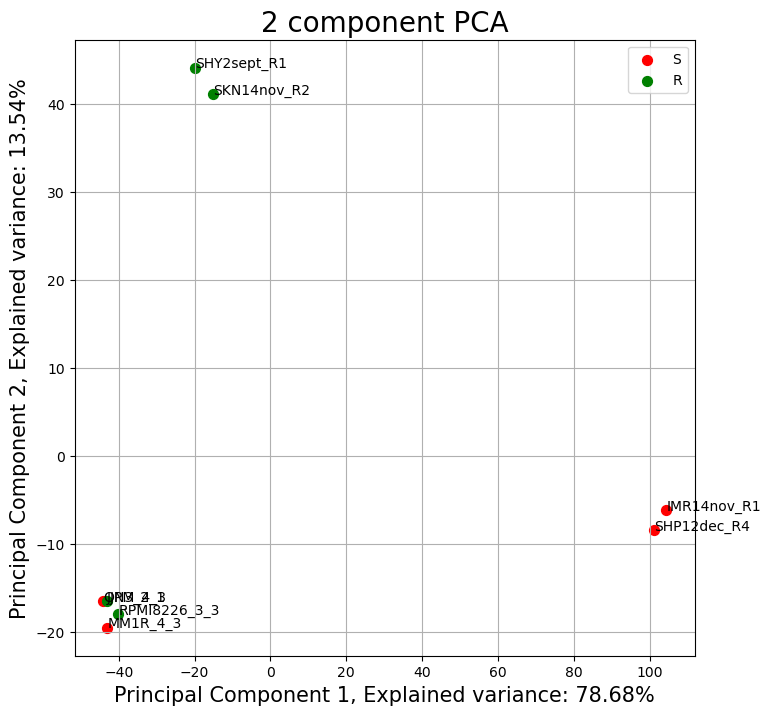

In [214]:
pca_plot(meth_seg_wgbs_fm, n_components=2, group_column="Group", label_column = "sample_id_adj")

## Model Training

### WGBS_tools

In [210]:
meth_seg_wgbs_fm = pd.read_csv("/data/lvisser/feature_matrices/meth_seg_wgbs_fm.csv")

Regularization has removed 30696 features of the original 37200.
Sample: 0
Cell line: JJN3_2_1
True label: R
Predicted label: R
Probabilities:
['R']: 0.8829245117254592
['S']: 0.1170754882745409

Sample: 1
Cell line: MM1R_4_3
True label: S
Predicted label: R
Probabilities:
['R']: 0.8754676368307885
['S']: 0.12453236316921146

Sample: 2
Cell line: OPM_4_3
True label: S
Predicted label: R
Probabilities:
['R']: 0.8821477239086515
['S']: 0.11785227609134846

Sample: 3
Cell line: RPMI8226_3_3
True label: R
Predicted label: R
Probabilities:
['R']: 0.865649285037573
['S']: 0.13435071496242704

PCA after filtering:


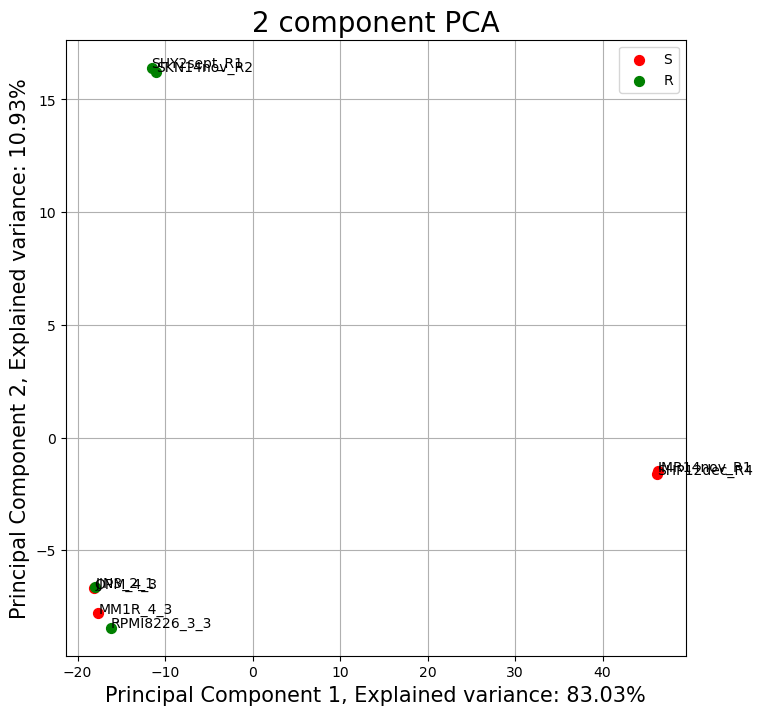

In [211]:
train_and_predict_single(meth_seg_wgbs_fm, train_indices = [0, 1, 2, 3], reg = True, pca = True)

### DBSCAN

In [212]:
meth_seg_dbscan_fm = pd.read_csv("/data/lvisser/feature_matrices/meth_seg_dbscan_fm.csv")

DMR has removed 24181 features of the original 51836.
Regularization has removed 27176 features of the original 27655.
Sample: 0
Cell line: SKN14nov_R2
True label: R
Predicted label: R
Probabilities:
['R']: 0.60906689035758
['S']: 0.39093310964242006

Sample: 1
Cell line: OPM_4_3
True label: S
Predicted label: R
Probabilities:
['R']: 0.9053220296350604
['S']: 0.09467797036493959

PCA after filtering:


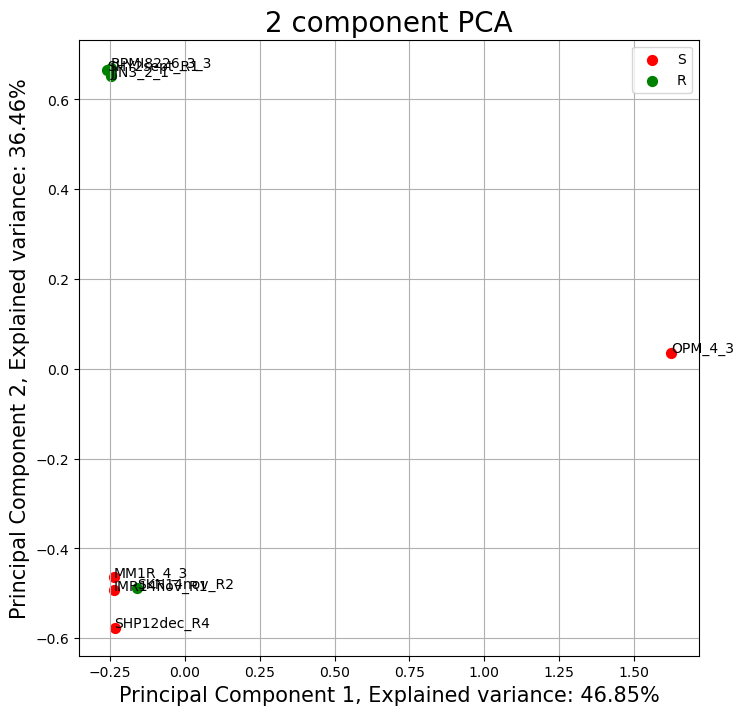

In [213]:
train_and_predict_single(meth_seg_dbscan_fm, reg = True, dmr = 'ttest', pca = True)

### Promotor Regions

In [56]:
meth_seg_promotors_fm = pd.read_csv("/data/lvisser/feature_matrices/meth_seg_promotors_fm.csv")

Regularization has removed 3479 features of the original 4561.
Sample: 0
Cell line: SHY2sept_R1
True label: R
Predicted label: R
Probabilities:
['R']: 0.5995158632506712
['S']: 0.40048413674932876

Sample: 1
Cell line: SKN14nov_R2
True label: R
Predicted label: R
Probabilities:
['R']: 0.8215309853507684
['S']: 0.17846901464923157

Sample: 2
Cell line: IMR14nov_R1
True label: S
Predicted label: R
Probabilities:
['R']: 0.6583255831993822
['S']: 0.3416744168006178

Sample: 3
Cell line: JJN3_2_1
True label: R
Predicted label: R
Probabilities:
['R']: 0.5037671098592877
['S']: 0.49623289014071226

PCA after filtering:


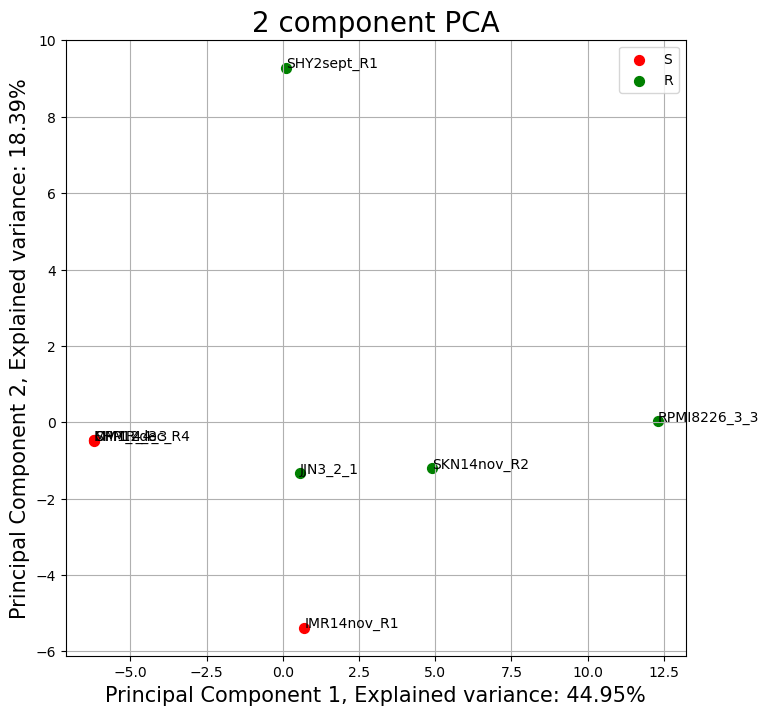

In [66]:
model, importances_df = train_and_predict_single(meth_seg_promotors_fm, test_size = 0.5, reg = True)

In [67]:
train_and_predict_loo(meth_seg_promotors_fm, reg = True)

Average accuracy: 0.625
Average F1 score: 0.25


### Gene Bodies

In [68]:
meth_seg_genebds_fm = pd.read_csv("/data/lvisser/feature_matrices/meth_seg_genebds_fm.csv")

Regularization has removed 6135 features of the original 6302.
Sample: 0
Cell line: MM1R_4_3
True label: S
Predicted label: R
Probabilities:
['R']: 0.5068652891959204
['S']: 0.49313471080407956

Sample: 1
Cell line: SHP12dec_R4
True label: S
Predicted label: S
Probabilities:
['R']: 0.39657683013641687
['S']: 0.6034231698635831

Sample: 2
Cell line: SKN14nov_R2
True label: R
Predicted label: R
Probabilities:
['R']: 0.5821450882189274
['S']: 0.4178549117810726

Sample: 3
Cell line: JJN3_2_1
True label: R
Predicted label: R
Probabilities:
['R']: 0.5716145800211532
['S']: 0.4283854199788469

PCA after filtering:


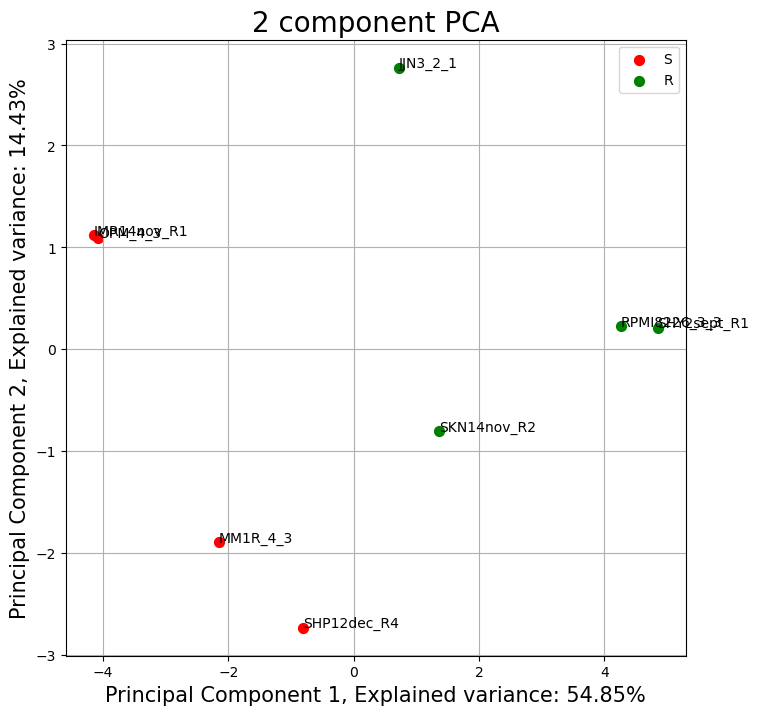

In [71]:
model, importances_df = train_and_predict_single(meth_seg_genebds_fm, test_size = 0.5, reg = True)

In [72]:
train_and_predict_loo(meth_seg_genebds_fm, reg = True)

Average accuracy: 0.5
Average F1 score: 0.0
